In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [33]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = 1.5 * reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [34]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [35]:
# vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))  # change lr from 0.001 (default) to 0.0001

In [36]:
model_version_old = "0.0.0.9_lr0.0001_50moreepochs"
vae.load_weights(base_dir + '/vae_' + model_version_old + '.h5')

Epoch 6400/6400
505/505  - 6s 11ms/step - loss: 413.2836 - reconstruction_loss: 411.7152 - kl_loss: 1.5683

In [37]:
model_version = "0.0.1.0_reconstrweight1.5"
os.system('mkdir ' + base_dir + '/weights_vae_' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights_vae_' + model_version + '/weights.{epoch:02d}-{loss:.2f}.h5', monitor='loss',
    verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq=505)


history_callback = vae.fit(x_train, epochs=50 * batch_size, batch_size=batch_size)


vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Epoch 1/6400
505/505 [==============================] - 5s 11ms/step - loss: 620.0826 - reconstruction_loss: 412.2471 - kl_loss: 1.7119
Epoch 2/6400
505/505 [==============================] - 5s 11ms/step - loss: 619.9046 - reconstruction_loss: 412.1303 - kl_loss: 1.7092
Epoch 3/6400
505/505 [==============================] - 5s 11ms/step - loss: 619.9244 - reconstruction_loss: 412.1431 - kl_loss: 1.7098
Epoch 4/6400
505/505 [==============================] - 5s 11ms/step - loss: 619.8656 - reconstruction_loss: 412.1029 - kl_loss: 1.7112
Epoch 5/6400
505/505 [==============================] - 5s 11ms/step - loss: 619.9640 - reconstruction_loss: 412.1695 - kl_loss: 1.7098
Epoch 6/6400
505/505 [==============================] - 5s 11ms/step - loss: 619.9412 - reconstruction_loss: 412.1540 - kl_loss: 1.7102
Epoch 7/6400
505/505 [==============================] - 5s 11ms/step - loss: 619.8993 - reconstruction_loss: 412.1259 - kl_loss: 1.7105
Epoch 8/6400
505/505 [==========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7458 - reconstruction_loss: 412.0233 - kl_loss: 1.7108
Epoch 61/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7562 - reconstruction_loss: 412.0300 - kl_loss: 1.7112
Epoch 62/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8089 - reconstruction_loss: 412.0653 - kl_loss: 1.7109
Epoch 63/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8594 - reconstruction_loss: 412.0988 - kl_loss: 1.7112
Epoch 64/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7950 - reconstruction_loss: 412.0561 - kl_loss: 1.7109
Epoch 65/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7265 - reconstruction_loss: 412.0105 - kl_loss: 1.7107
Epoch 66/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7997 - reconstruction_loss: 412.0587 - kl_loss: 1.7116
Epoch 67/6400
505/505 [==============================] 

505/505 [==============================] - 6s 11ms/step - loss: 619.8053 - reconstruction_loss: 412.0619 - kl_loss: 1.7125
Epoch 120/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7771 - reconstruction_loss: 412.0433 - kl_loss: 1.7122
Epoch 121/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8126 - reconstruction_loss: 412.0667 - kl_loss: 1.7125
Epoch 122/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7870 - reconstruction_loss: 412.0503 - kl_loss: 1.7116
Epoch 123/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8195 - reconstruction_loss: 412.0719 - kl_loss: 1.7116
Epoch 124/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8110 - reconstruction_loss: 412.0654 - kl_loss: 1.7129
Epoch 125/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8049 - reconstruction_loss: 412.0613 - kl_loss: 1.7130
Epoch 126/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7522 - reconstruction_loss: 412.0268 - kl_loss: 1.7120
Epoch 179/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8227 - reconstruction_loss: 412.0736 - kl_loss: 1.7122
Epoch 180/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6971 - reconstruction_loss: 411.9893 - kl_loss: 1.7131
Epoch 181/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7102 - reconstruction_loss: 411.9989 - kl_loss: 1.7118
Epoch 182/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7964 - reconstruction_loss: 412.0566 - kl_loss: 1.7114
Epoch 183/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7275 - reconstruction_loss: 412.0095 - kl_loss: 1.7133
Epoch 184/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7565 - reconstruction_loss: 412.0292 - kl_loss: 1.7127
Epoch 185/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.8543 - reconstruction_loss: 412.0939 - kl_loss: 1.7134
Epoch 238/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7515 - reconstruction_loss: 412.0259 - kl_loss: 1.7127
Epoch 239/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7852 - reconstruction_loss: 412.0478 - kl_loss: 1.7134
Epoch 240/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7773 - reconstruction_loss: 412.0432 - kl_loss: 1.7126
Epoch 241/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7695 - reconstruction_loss: 412.0368 - kl_loss: 1.7143
Epoch 242/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6628 - reconstruction_loss: 411.9664 - kl_loss: 1.7132
Epoch 243/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7351 - reconstruction_loss: 412.0152 - kl_loss: 1.7123
Epoch 244/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7739 - reconstruction_loss: 412.0406 - kl_loss: 1.7129
Epoch 297/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7742 - reconstruction_loss: 412.0414 - kl_loss: 1.7122
Epoch 298/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7316 - reconstruction_loss: 412.0119 - kl_loss: 1.7137
Epoch 299/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8178 - reconstruction_loss: 412.0698 - kl_loss: 1.7131
Epoch 300/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7801 - reconstruction_loss: 412.0442 - kl_loss: 1.7138
Epoch 301/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6681 - reconstruction_loss: 411.9696 - kl_loss: 1.7137
Epoch 302/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7509 - reconstruction_loss: 412.0250 - kl_loss: 1.7135
Epoch 303/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7785 - reconstruction_loss: 412.0431 - kl_loss: 1.7139
Epoch 356/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7502 - reconstruction_loss: 412.0240 - kl_loss: 1.7142
Epoch 357/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7913 - reconstruction_loss: 412.0519 - kl_loss: 1.7134
Epoch 358/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7448 - reconstruction_loss: 412.0207 - kl_loss: 1.7138
Epoch 359/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7782 - reconstruction_loss: 412.0435 - kl_loss: 1.7130
Epoch 360/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8055 - reconstruction_loss: 412.0614 - kl_loss: 1.7134
Epoch 361/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7039 - reconstruction_loss: 411.9931 - kl_loss: 1.7143
Epoch 362/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7369 - reconstruction_loss: 412.0147 - kl_loss: 1.7149
Epoch 415/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7539 - reconstruction_loss: 412.0263 - kl_loss: 1.7144
Epoch 416/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7712 - reconstruction_loss: 412.0379 - kl_loss: 1.7143
Epoch 417/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7812 - reconstruction_loss: 412.0439 - kl_loss: 1.7154
Epoch 418/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7497 - reconstruction_loss: 412.0232 - kl_loss: 1.7149
Epoch 419/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7300 - reconstruction_loss: 412.0105 - kl_loss: 1.7143
Epoch 420/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7322 - reconstruction_loss: 412.0124 - kl_loss: 1.7137
Epoch 421/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7942 - reconstruction_loss: 412.0533 - kl_loss: 1.7143
Epoch 474/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7331 - reconstruction_loss: 412.0119 - kl_loss: 1.7153
Epoch 475/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8229 - reconstruction_loss: 412.0723 - kl_loss: 1.7145
Epoch 476/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7116 - reconstruction_loss: 411.9977 - kl_loss: 1.7151
Epoch 477/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7961 - reconstruction_loss: 412.0549 - kl_loss: 1.7138
Epoch 478/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7041 - reconstruction_loss: 411.9925 - kl_loss: 1.7152
Epoch 479/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7914 - reconstruction_loss: 412.0519 - kl_loss: 1.7136
Epoch 480/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7528 - reconstruction_loss: 412.0251 - kl_loss: 1.7151
Epoch 533/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7550 - reconstruction_loss: 412.0262 - kl_loss: 1.7157
Epoch 534/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7735 - reconstruction_loss: 412.0390 - kl_loss: 1.7150
Epoch 535/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7651 - reconstruction_loss: 412.0337 - kl_loss: 1.7146
Epoch 536/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6740 - reconstruction_loss: 411.9725 - kl_loss: 1.7152
Epoch 537/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7197 - reconstruction_loss: 412.0038 - kl_loss: 1.7140
Epoch 538/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7950 - reconstruction_loss: 412.0527 - kl_loss: 1.7159
Epoch 539/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7124 - reconstruction_loss: 411.9981 - kl_loss: 1.7153
Epoch 592/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7158 - reconstruction_loss: 412.0007 - kl_loss: 1.7148
Epoch 593/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7675 - reconstruction_loss: 412.0345 - kl_loss: 1.7158
Epoch 594/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7291 - reconstruction_loss: 412.0095 - kl_loss: 1.7149
Epoch 595/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7370 - reconstruction_loss: 412.0153 - kl_loss: 1.7141
Epoch 596/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7901 - reconstruction_loss: 412.0499 - kl_loss: 1.7153
Epoch 597/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7654 - reconstruction_loss: 412.0341 - kl_loss: 1.7141
Epoch 598/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7706 - reconstruction_loss: 412.0365 - kl_loss: 1.7159
Epoch 651/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7522 - reconstruction_loss: 412.0244 - kl_loss: 1.7156
Epoch 652/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7283 - reconstruction_loss: 412.0086 - kl_loss: 1.7155
Epoch 653/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7385 - reconstruction_loss: 412.0151 - kl_loss: 1.7159
Epoch 654/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7824 - reconstruction_loss: 412.0450 - kl_loss: 1.7149
Epoch 655/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6667 - reconstruction_loss: 411.9674 - kl_loss: 1.7155
Epoch 656/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7735 - reconstruction_loss: 412.0391 - kl_loss: 1.7148
Epoch 657/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.6944 - reconstruction_loss: 411.9860 - kl_loss: 1.7154
Epoch 710/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8221 - reconstruction_loss: 412.0715 - kl_loss: 1.7149
Epoch 711/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7857 - reconstruction_loss: 412.0472 - kl_loss: 1.7149
Epoch 712/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7447 - reconstruction_loss: 412.0197 - kl_loss: 1.7151
Epoch 713/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6979 - reconstruction_loss: 411.9885 - kl_loss: 1.7152
Epoch 714/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6764 - reconstruction_loss: 411.9744 - kl_loss: 1.7147
Epoch 715/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7027 - reconstruction_loss: 411.9916 - kl_loss: 1.7153
Epoch 716/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7434 - reconstruction_loss: 412.0188 - kl_loss: 1.7152
Epoch 769/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7103 - reconstruction_loss: 411.9956 - kl_loss: 1.7168
Epoch 770/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7772 - reconstruction_loss: 412.0408 - kl_loss: 1.7160
Epoch 771/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7107 - reconstruction_loss: 411.9968 - kl_loss: 1.7154
Epoch 772/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7208 - reconstruction_loss: 412.0041 - kl_loss: 1.7147
Epoch 773/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7138 - reconstruction_loss: 411.9989 - kl_loss: 1.7154
Epoch 774/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7556 - reconstruction_loss: 412.0266 - kl_loss: 1.7158
Epoch 775/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.6776 - reconstruction_loss: 411.9749 - kl_loss: 1.7152
Epoch 828/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7690 - reconstruction_loss: 412.0358 - kl_loss: 1.7153
Epoch 829/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7268 - reconstruction_loss: 412.0066 - kl_loss: 1.7169
Epoch 830/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7055 - reconstruction_loss: 411.9933 - kl_loss: 1.7154
Epoch 831/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7170 - reconstruction_loss: 412.0011 - kl_loss: 1.7153
Epoch 832/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7104 - reconstruction_loss: 411.9966 - kl_loss: 1.7155
Epoch 833/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7855 - reconstruction_loss: 412.0473 - kl_loss: 1.7145
Epoch 834/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7282 - reconstruction_loss: 412.0087 - kl_loss: 1.7151
Epoch 887/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7448 - reconstruction_loss: 412.0192 - kl_loss: 1.7160
Epoch 888/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7590 - reconstruction_loss: 412.0289 - kl_loss: 1.7157
Epoch 889/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7429 - reconstruction_loss: 412.0182 - kl_loss: 1.7156
Epoch 890/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7421 - reconstruction_loss: 412.0171 - kl_loss: 1.7165
Epoch 891/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8146 - reconstruction_loss: 412.0656 - kl_loss: 1.7161
Epoch 892/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6909 - reconstruction_loss: 411.9826 - kl_loss: 1.7169
Epoch 893/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7165 - reconstruction_loss: 412.0006 - kl_loss: 1.7156
Epoch 946/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6570 - reconstruction_loss: 411.9597 - kl_loss: 1.7174
Epoch 947/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7887 - reconstruction_loss: 412.0492 - kl_loss: 1.7150
Epoch 948/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7441 - reconstruction_loss: 412.0192 - kl_loss: 1.7153
Epoch 949/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6807 - reconstruction_loss: 411.9763 - kl_loss: 1.7163
Epoch 950/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8635 - reconstruction_loss: 412.0984 - kl_loss: 1.7158
Epoch 951/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8332 - reconstruction_loss: 412.0780 - kl_loss: 1.7162
Epoch 952/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 619.7812 - reconstruction_loss: 412.0429 - kl_loss: 1.7168
Epoch 1005/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6978 - reconstruction_loss: 411.9881 - kl_loss: 1.7157
Epoch 1006/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6827 - reconstruction_loss: 411.9771 - kl_loss: 1.7171
Epoch 1007/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7579 - reconstruction_loss: 412.0283 - kl_loss: 1.7154
Epoch 1008/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7390 - reconstruction_loss: 412.0150 - kl_loss: 1.7164
Epoch 1009/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7525 - reconstruction_loss: 412.0239 - kl_loss: 1.7167
Epoch 1010/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6576 - reconstruction_loss: 411.9609 - kl_loss: 1.7162
Epoch 1011/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7296 - reconstruction_loss: 412.0087 - kl_loss: 1.7165
Epoch 1064/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6070 - reconstruction_loss: 411.9270 - kl_loss: 1.7165
Epoch 1065/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6984 - reconstruction_loss: 411.9877 - kl_loss: 1.7168
Epoch 1066/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7638 - reconstruction_loss: 412.0326 - kl_loss: 1.7149
Epoch 1067/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7022 - reconstruction_loss: 411.9898 - kl_loss: 1.7174
Epoch 1068/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7192 - reconstruction_loss: 412.0028 - kl_loss: 1.7150
Epoch 1069/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6784 - reconstruction_loss: 411.9745 - kl_loss: 1.7166
Epoch 1070/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6906 - reconstruction_loss: 411.9828 - kl_loss: 1.7163
Epoch 1123/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7393 - reconstruction_loss: 412.0151 - kl_loss: 1.7167
Epoch 1124/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6340 - reconstruction_loss: 411.9442 - kl_loss: 1.7178
Epoch 1125/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7376 - reconstruction_loss: 412.0148 - kl_loss: 1.7154
Epoch 1126/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8100 - reconstruction_loss: 412.0619 - kl_loss: 1.7172
Epoch 1127/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7143 - reconstruction_loss: 411.9985 - kl_loss: 1.7165
Epoch 1128/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6760 - reconstruction_loss: 411.9729 - kl_loss: 1.7166
Epoch 1129/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6912 - reconstruction_loss: 411.9830 - kl_loss: 1.7168
Epoch 1182/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7628 - reconstruction_loss: 412.0302 - kl_loss: 1.7175
Epoch 1183/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6782 - reconstruction_loss: 411.9745 - kl_loss: 1.7165
Epoch 1184/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6342 - reconstruction_loss: 411.9448 - kl_loss: 1.7170
Epoch 1185/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7517 - reconstruction_loss: 412.0234 - kl_loss: 1.7167
Epoch 1186/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7142 - reconstruction_loss: 411.9979 - kl_loss: 1.7172
Epoch 1187/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6901 - reconstruction_loss: 411.9818 - kl_loss: 1.7174
Epoch 1188/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6814 - reconstruction_loss: 411.9761 - kl_loss: 1.7173
Epoch 1241/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7663 - reconstruction_loss: 412.0333 - kl_loss: 1.7163
Epoch 1242/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7581 - reconstruction_loss: 412.0280 - kl_loss: 1.7161
Epoch 1243/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7107 - reconstruction_loss: 411.9960 - kl_loss: 1.7167
Epoch 1244/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7218 - reconstruction_loss: 412.0029 - kl_loss: 1.7174
Epoch 1245/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8100 - reconstruction_loss: 412.0609 - kl_loss: 1.7187
Epoch 1246/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7185 - reconstruction_loss: 412.0006 - kl_loss: 1.7177
Epoch 1247/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7607 - reconstruction_loss: 412.0297 - kl_loss: 1.7161
Epoch 1300/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7851 - reconstruction_loss: 412.0456 - kl_loss: 1.7168
Epoch 1301/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6498 - reconstruction_loss: 411.9550 - kl_loss: 1.7174
Epoch 1302/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7001 - reconstruction_loss: 411.9887 - kl_loss: 1.7171
Epoch 1303/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8209 - reconstruction_loss: 412.0706 - kl_loss: 1.7150
Epoch 1304/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7370 - reconstruction_loss: 412.0133 - kl_loss: 1.7170
Epoch 1305/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7217 - reconstruction_loss: 412.0031 - kl_loss: 1.7170
Epoch 1306/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7704 - reconstruction_loss: 412.0353 - kl_loss: 1.7174
Epoch 1359/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7650 - reconstruction_loss: 412.0316 - kl_loss: 1.7175
Epoch 1360/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6714 - reconstruction_loss: 411.9696 - kl_loss: 1.7170
Epoch 1361/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8199 - reconstruction_loss: 412.0698 - kl_loss: 1.7151
Epoch 1362/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7137 - reconstruction_loss: 411.9975 - kl_loss: 1.7174
Epoch 1363/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7032 - reconstruction_loss: 411.9913 - kl_loss: 1.7163
Epoch 1364/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6896 - reconstruction_loss: 411.9819 - kl_loss: 1.7167
Epoch 1365/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7135 - reconstruction_loss: 411.9975 - kl_loss: 1.7173
Epoch 1418/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6401 - reconstruction_loss: 411.9485 - kl_loss: 1.7174
Epoch 1419/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7309 - reconstruction_loss: 412.0096 - kl_loss: 1.7166
Epoch 1420/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7916 - reconstruction_loss: 412.0495 - kl_loss: 1.7173
Epoch 1421/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7879 - reconstruction_loss: 412.0471 - kl_loss: 1.7172
Epoch 1422/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7199 - reconstruction_loss: 412.0016 - kl_loss: 1.7175
Epoch 1423/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7408 - reconstruction_loss: 412.0149 - kl_loss: 1.7185
Epoch 1424/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7643 - reconstruction_loss: 412.0310 - kl_loss: 1.7178
Epoch 1477/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7258 - reconstruction_loss: 412.0063 - kl_loss: 1.7164
Epoch 1478/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7361 - reconstruction_loss: 412.0125 - kl_loss: 1.7173
Epoch 1479/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8092 - reconstruction_loss: 412.0606 - kl_loss: 1.7183
Epoch 1480/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7340 - reconstruction_loss: 412.0110 - kl_loss: 1.7174
Epoch 1481/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7536 - reconstruction_loss: 412.0236 - kl_loss: 1.7183
Epoch 1482/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7766 - reconstruction_loss: 412.0395 - kl_loss: 1.7175
Epoch 1483/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.8270 - reconstruction_loss: 412.0761 - kl_loss: 1.7129
Epoch 1536/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8769 - reconstruction_loss: 412.1091 - kl_loss: 1.7132
Epoch 1537/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7126 - reconstruction_loss: 411.9991 - kl_loss: 1.7140
Epoch 1538/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8206 - reconstruction_loss: 412.0704 - kl_loss: 1.7150
Epoch 1539/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8097 - reconstruction_loss: 412.0637 - kl_loss: 1.7141
Epoch 1540/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7770 - reconstruction_loss: 412.0419 - kl_loss: 1.7142
Epoch 1541/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7506 - reconstruction_loss: 412.0236 - kl_loss: 1.7152
Epoch 1542/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7464 - reconstruction_loss: 412.0201 - kl_loss: 1.7162
Epoch 1595/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7226 - reconstruction_loss: 412.0032 - kl_loss: 1.7178
Epoch 1596/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7903 - reconstruction_loss: 412.0503 - kl_loss: 1.7148
Epoch 1597/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7966 - reconstruction_loss: 412.0548 - kl_loss: 1.7144
Epoch 1598/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.9971 - reconstruction_loss: 412.1889 - kl_loss: 1.7137
Epoch 1599/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8409 - reconstruction_loss: 412.0836 - kl_loss: 1.7156
Epoch 1600/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8043 - reconstruction_loss: 412.0583 - kl_loss: 1.7169
Epoch 1601/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7185 - reconstruction_loss: 412.0015 - kl_loss: 1.7163
Epoch 1654/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7490 - reconstruction_loss: 412.0219 - kl_loss: 1.7162
Epoch 1655/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8014 - reconstruction_loss: 412.0575 - kl_loss: 1.7152
Epoch 1656/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6810 - reconstruction_loss: 411.9764 - kl_loss: 1.7164
Epoch 1657/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7378 - reconstruction_loss: 412.0148 - kl_loss: 1.7156
Epoch 1658/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7367 - reconstruction_loss: 412.0135 - kl_loss: 1.7164
Epoch 1659/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7440 - reconstruction_loss: 412.0187 - kl_loss: 1.7159
Epoch 1660/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7531 - reconstruction_loss: 412.0247 - kl_loss: 1.7161
Epoch 1713/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7386 - reconstruction_loss: 412.0151 - kl_loss: 1.7159
Epoch 1714/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8298 - reconstruction_loss: 412.0760 - kl_loss: 1.7158
Epoch 1715/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7713 - reconstruction_loss: 412.0367 - kl_loss: 1.7163
Epoch 1716/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8374 - reconstruction_loss: 412.0805 - kl_loss: 1.7167
Epoch 1717/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7838 - reconstruction_loss: 412.0446 - kl_loss: 1.7169
Epoch 1718/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7686 - reconstruction_loss: 412.0349 - kl_loss: 1.7162
Epoch 1719/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.8201 - reconstruction_loss: 412.0688 - kl_loss: 1.7169
Epoch 1772/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7109 - reconstruction_loss: 411.9963 - kl_loss: 1.7164
Epoch 1773/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7756 - reconstruction_loss: 412.0395 - kl_loss: 1.7163
Epoch 1774/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7327 - reconstruction_loss: 412.0109 - kl_loss: 1.7164
Epoch 1775/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7991 - reconstruction_loss: 412.0550 - kl_loss: 1.7167
Epoch 1776/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7918 - reconstruction_loss: 412.0505 - kl_loss: 1.7160
Epoch 1777/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7422 - reconstruction_loss: 412.0171 - kl_loss: 1.7166
Epoch 1778/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7239 - reconstruction_loss: 412.0054 - kl_loss: 1.7158
Epoch 1831/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8049 - reconstruction_loss: 412.0591 - kl_loss: 1.7162
Epoch 1832/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6689 - reconstruction_loss: 411.9678 - kl_loss: 1.7172
Epoch 1833/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7414 - reconstruction_loss: 412.0163 - kl_loss: 1.7170
Epoch 1834/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7319 - reconstruction_loss: 412.0099 - kl_loss: 1.7170
Epoch 1835/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7653 - reconstruction_loss: 412.0325 - kl_loss: 1.7165
Epoch 1836/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7564 - reconstruction_loss: 412.0266 - kl_loss: 1.7164
Epoch 1837/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6901 - reconstruction_loss: 411.9818 - kl_loss: 1.7173
Epoch 1890/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8127 - reconstruction_loss: 412.0634 - kl_loss: 1.7177
Epoch 1891/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8145 - reconstruction_loss: 412.0650 - kl_loss: 1.7171
Epoch 1892/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7516 - reconstruction_loss: 412.0224 - kl_loss: 1.7181
Epoch 1893/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7049 - reconstruction_loss: 411.9909 - kl_loss: 1.7186
Epoch 1894/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7560 - reconstruction_loss: 412.0259 - kl_loss: 1.7171
Epoch 1895/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7308 - reconstruction_loss: 412.0091 - kl_loss: 1.7172
Epoch 1896/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.8428 - reconstruction_loss: 412.0833 - kl_loss: 1.7178
Epoch 1949/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7460 - reconstruction_loss: 412.0192 - kl_loss: 1.7172
Epoch 1950/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7809 - reconstruction_loss: 412.0422 - kl_loss: 1.7177
Epoch 1951/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8086 - reconstruction_loss: 412.0606 - kl_loss: 1.7178
Epoch 1952/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7913 - reconstruction_loss: 412.0492 - kl_loss: 1.7175
Epoch 1953/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7189 - reconstruction_loss: 412.0013 - kl_loss: 1.7169
Epoch 1954/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7298 - reconstruction_loss: 412.0083 - kl_loss: 1.7173
Epoch 1955/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7134 - reconstruction_loss: 411.9972 - kl_loss: 1.7176
Epoch 2008/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7715 - reconstruction_loss: 412.0362 - kl_loss: 1.7173
Epoch 2009/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8101 - reconstruction_loss: 412.0625 - kl_loss: 1.7164
Epoch 2010/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8134 - reconstruction_loss: 412.0640 - kl_loss: 1.7173
Epoch 2011/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7510 - reconstruction_loss: 412.0229 - kl_loss: 1.7167
Epoch 2012/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7476 - reconstruction_loss: 412.0204 - kl_loss: 1.7170
Epoch 2013/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7404 - reconstruction_loss: 412.0150 - kl_loss: 1.7179
Epoch 2014/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7268 - reconstruction_loss: 412.0060 - kl_loss: 1.7178
Epoch 2067/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7594 - reconstruction_loss: 412.0281 - kl_loss: 1.7172
Epoch 2068/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7799 - reconstruction_loss: 412.0417 - kl_loss: 1.7174
Epoch 2069/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8081 - reconstruction_loss: 412.0612 - kl_loss: 1.7163
Epoch 2070/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7014 - reconstruction_loss: 411.9888 - kl_loss: 1.7183
Epoch 2071/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7938 - reconstruction_loss: 412.0507 - kl_loss: 1.7178
Epoch 2072/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7828 - reconstruction_loss: 412.0438 - kl_loss: 1.7171
Epoch 2073/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7192 - reconstruction_loss: 412.0011 - kl_loss: 1.7176
Epoch 2126/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8169 - reconstruction_loss: 412.0660 - kl_loss: 1.7179
Epoch 2127/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7497 - reconstruction_loss: 412.0212 - kl_loss: 1.7179
Epoch 2128/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7727 - reconstruction_loss: 412.0359 - kl_loss: 1.7188
Epoch 2129/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7654 - reconstruction_loss: 412.0314 - kl_loss: 1.7183
Epoch 2130/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6996 - reconstruction_loss: 411.9878 - kl_loss: 1.7180
Epoch 2131/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7401 - reconstruction_loss: 412.0145 - kl_loss: 1.7183
Epoch 2132/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7365 - reconstruction_loss: 412.0124 - kl_loss: 1.7178
Epoch 2185/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7424 - reconstruction_loss: 412.0164 - kl_loss: 1.7177
Epoch 2186/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7949 - reconstruction_loss: 412.0509 - kl_loss: 1.7185
Epoch 2187/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6499 - reconstruction_loss: 411.9550 - kl_loss: 1.7174
Epoch 2188/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7513 - reconstruction_loss: 412.0218 - kl_loss: 1.7186
Epoch 2189/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6710 - reconstruction_loss: 411.9685 - kl_loss: 1.7182
Epoch 2190/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6747 - reconstruction_loss: 411.9712 - kl_loss: 1.7179
Epoch 2191/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6878 - reconstruction_loss: 411.9806 - kl_loss: 1.7168
Epoch 2244/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6698 - reconstruction_loss: 411.9673 - kl_loss: 1.7190
Epoch 2245/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7810 - reconstruction_loss: 412.0418 - kl_loss: 1.7183
Epoch 2246/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7464 - reconstruction_loss: 412.0184 - kl_loss: 1.7188
Epoch 2247/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7481 - reconstruction_loss: 412.0200 - kl_loss: 1.7181
Epoch 2248/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7940 - reconstruction_loss: 412.0508 - kl_loss: 1.7178
Epoch 2249/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8075 - reconstruction_loss: 412.0594 - kl_loss: 1.7183
Epoch 2250/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7356 - reconstruction_loss: 412.0115 - kl_loss: 1.7184
Epoch 2303/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7497 - reconstruction_loss: 412.0215 - kl_loss: 1.7175
Epoch 2304/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7449 - reconstruction_loss: 412.0180 - kl_loss: 1.7179
Epoch 2305/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7331 - reconstruction_loss: 412.0094 - kl_loss: 1.7190
Epoch 2306/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7361 - reconstruction_loss: 412.0128 - kl_loss: 1.7170
Epoch 2307/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6882 - reconstruction_loss: 411.9800 - kl_loss: 1.7182
Epoch 2308/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6635 - reconstruction_loss: 411.9636 - kl_loss: 1.7181
Epoch 2309/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6907 - reconstruction_loss: 411.9816 - kl_loss: 1.7183
Epoch 2362/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7987 - reconstruction_loss: 412.0537 - kl_loss: 1.7181
Epoch 2363/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7080 - reconstruction_loss: 411.9930 - kl_loss: 1.7184
Epoch 2364/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7305 - reconstruction_loss: 412.0079 - kl_loss: 1.7186
Epoch 2365/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7974 - reconstruction_loss: 412.0529 - kl_loss: 1.7180
Epoch 2366/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7502 - reconstruction_loss: 412.0208 - kl_loss: 1.7190
Epoch 2367/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7427 - reconstruction_loss: 412.0157 - kl_loss: 1.7191
Epoch 2368/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6982 - reconstruction_loss: 411.9861 - kl_loss: 1.7190
Epoch 2421/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7930 - reconstruction_loss: 412.0503 - kl_loss: 1.7176
Epoch 2422/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7252 - reconstruction_loss: 412.0039 - kl_loss: 1.7193
Epoch 2423/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7051 - reconstruction_loss: 411.9909 - kl_loss: 1.7187
Epoch 2424/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8136 - reconstruction_loss: 412.0640 - kl_loss: 1.7176
Epoch 2425/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8224 - reconstruction_loss: 412.0699 - kl_loss: 1.7175
Epoch 2426/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7316 - reconstruction_loss: 412.0086 - kl_loss: 1.7188
Epoch 2427/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7624 - reconstruction_loss: 412.0292 - kl_loss: 1.7185
Epoch 2480/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7907 - reconstruction_loss: 412.0479 - kl_loss: 1.7188
Epoch 2481/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7833 - reconstruction_loss: 412.0430 - kl_loss: 1.7188
Epoch 2482/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7786 - reconstruction_loss: 412.0402 - kl_loss: 1.7183
Epoch 2483/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7790 - reconstruction_loss: 412.0402 - kl_loss: 1.7188
Epoch 2484/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8035 - reconstruction_loss: 412.0565 - kl_loss: 1.7187
Epoch 2485/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7548 - reconstruction_loss: 412.0244 - kl_loss: 1.7182
Epoch 2486/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6805 - reconstruction_loss: 411.9741 - kl_loss: 1.7193
Epoch 2539/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7250 - reconstruction_loss: 412.0048 - kl_loss: 1.7177
Epoch 2540/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7287 - reconstruction_loss: 412.0070 - kl_loss: 1.7183
Epoch 2541/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6971 - reconstruction_loss: 411.9855 - kl_loss: 1.7188
Epoch 2542/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7714 - reconstruction_loss: 412.0350 - kl_loss: 1.7189
Epoch 2543/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7602 - reconstruction_loss: 412.0270 - kl_loss: 1.7198
Epoch 2544/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8420 - reconstruction_loss: 412.0818 - kl_loss: 1.7193
Epoch 2545/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7729 - reconstruction_loss: 412.0362 - kl_loss: 1.7186
Epoch 2598/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7756 - reconstruction_loss: 412.0374 - kl_loss: 1.7194
Epoch 2599/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6827 - reconstruction_loss: 411.9757 - kl_loss: 1.7192
Epoch 2600/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7621 - reconstruction_loss: 412.0289 - kl_loss: 1.7187
Epoch 2601/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6527 - reconstruction_loss: 411.9557 - kl_loss: 1.7191
Epoch 2602/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7279 - reconstruction_loss: 412.0066 - kl_loss: 1.7179
Epoch 2603/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6780 - reconstruction_loss: 411.9720 - kl_loss: 1.7200
Epoch 2604/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7249 - reconstruction_loss: 412.0041 - kl_loss: 1.7187
Epoch 2657/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7066 - reconstruction_loss: 411.9916 - kl_loss: 1.7193
Epoch 2658/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6742 - reconstruction_loss: 411.9698 - kl_loss: 1.7196
Epoch 2659/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7057 - reconstruction_loss: 411.9903 - kl_loss: 1.7202
Epoch 2660/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7235 - reconstruction_loss: 412.0036 - kl_loss: 1.7181
Epoch 2661/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7900 - reconstruction_loss: 412.0475 - kl_loss: 1.7188
Epoch 2662/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8487 - reconstruction_loss: 412.0864 - kl_loss: 1.7190
Epoch 2663/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7972 - reconstruction_loss: 412.0520 - kl_loss: 1.7192
Epoch 2716/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7565 - reconstruction_loss: 412.0252 - kl_loss: 1.7187
Epoch 2717/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6948 - reconstruction_loss: 411.9831 - kl_loss: 1.7201
Epoch 2718/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7088 - reconstruction_loss: 411.9924 - kl_loss: 1.7202
Epoch 2719/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8495 - reconstruction_loss: 412.0874 - kl_loss: 1.7185
Epoch 2720/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7394 - reconstruction_loss: 412.0138 - kl_loss: 1.7187
Epoch 2721/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7291 - reconstruction_loss: 412.0066 - kl_loss: 1.7191
Epoch 2722/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7459 - reconstruction_loss: 412.0182 - kl_loss: 1.7186
Epoch 2775/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7029 - reconstruction_loss: 411.9896 - kl_loss: 1.7184
Epoch 2776/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7585 - reconstruction_loss: 412.0264 - kl_loss: 1.7188
Epoch 2777/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8007 - reconstruction_loss: 412.0539 - kl_loss: 1.7198
Epoch 2778/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8217 - reconstruction_loss: 412.0688 - kl_loss: 1.7185
Epoch 2779/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6853 - reconstruction_loss: 411.9774 - kl_loss: 1.7192
Epoch 2780/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7534 - reconstruction_loss: 412.0227 - kl_loss: 1.7194
Epoch 2781/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.8176 - reconstruction_loss: 412.0660 - kl_loss: 1.7186
Epoch 2834/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8110 - reconstruction_loss: 412.0611 - kl_loss: 1.7193
Epoch 2835/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7295 - reconstruction_loss: 412.0065 - kl_loss: 1.7198
Epoch 2836/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8014 - reconstruction_loss: 412.0540 - kl_loss: 1.7204
Epoch 2837/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7217 - reconstruction_loss: 412.0023 - kl_loss: 1.7182
Epoch 2838/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7419 - reconstruction_loss: 412.0143 - kl_loss: 1.7204
Epoch 2839/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7161 - reconstruction_loss: 411.9980 - kl_loss: 1.7192
Epoch 2840/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7817 - reconstruction_loss: 412.0415 - kl_loss: 1.7195
Epoch 2893/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7070 - reconstruction_loss: 411.9907 - kl_loss: 1.7209
Epoch 2894/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7664 - reconstruction_loss: 412.0317 - kl_loss: 1.7189
Epoch 2895/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7738 - reconstruction_loss: 412.0366 - kl_loss: 1.7190
Epoch 2896/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7301 - reconstruction_loss: 412.0072 - kl_loss: 1.7193
Epoch 2897/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7992 - reconstruction_loss: 412.0533 - kl_loss: 1.7192
Epoch 2898/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7660 - reconstruction_loss: 412.0308 - kl_loss: 1.7197
Epoch 2899/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7376 - reconstruction_loss: 412.0118 - kl_loss: 1.7199
Epoch 2952/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7885 - reconstruction_loss: 412.0452 - kl_loss: 1.7207
Epoch 2953/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7759 - reconstruction_loss: 412.0378 - kl_loss: 1.7192
Epoch 2954/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7589 - reconstruction_loss: 412.0262 - kl_loss: 1.7196
Epoch 2955/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6592 - reconstruction_loss: 411.9588 - kl_loss: 1.7210
Epoch 2956/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7145 - reconstruction_loss: 411.9963 - kl_loss: 1.7200
Epoch 2957/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7755 - reconstruction_loss: 412.0371 - kl_loss: 1.7198
Epoch 2958/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7904 - reconstruction_loss: 412.0479 - kl_loss: 1.7185
Epoch 3011/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8207 - reconstruction_loss: 412.0676 - kl_loss: 1.7193
Epoch 3012/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6615 - reconstruction_loss: 411.9605 - kl_loss: 1.7208
Epoch 3013/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7292 - reconstruction_loss: 412.0058 - kl_loss: 1.7205
Epoch 3014/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7777 - reconstruction_loss: 412.0387 - kl_loss: 1.7197
Epoch 3015/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7466 - reconstruction_loss: 412.0180 - kl_loss: 1.7195
Epoch 3016/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7446 - reconstruction_loss: 412.0161 - kl_loss: 1.7204
Epoch 3017/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7463 - reconstruction_loss: 412.0175 - kl_loss: 1.7201
Epoch 3070/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7966 - reconstruction_loss: 412.0512 - kl_loss: 1.7198
Epoch 3071/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7806 - reconstruction_loss: 412.0408 - kl_loss: 1.7194
Epoch 3072/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7298 - reconstruction_loss: 412.0063 - kl_loss: 1.7204
Epoch 3073/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6855 - reconstruction_loss: 411.9775 - kl_loss: 1.7192
Epoch 3074/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6930 - reconstruction_loss: 411.9823 - kl_loss: 1.7196
Epoch 3075/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6917 - reconstruction_loss: 411.9812 - kl_loss: 1.7200
Epoch 3076/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6916 - reconstruction_loss: 411.9805 - kl_loss: 1.7208
Epoch 3129/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7423 - reconstruction_loss: 412.0144 - kl_loss: 1.7208
Epoch 3130/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6749 - reconstruction_loss: 411.9697 - kl_loss: 1.7203
Epoch 3131/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7283 - reconstruction_loss: 412.0050 - kl_loss: 1.7209
Epoch 3132/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7335 - reconstruction_loss: 412.0088 - kl_loss: 1.7203
Epoch 3133/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7480 - reconstruction_loss: 412.0188 - kl_loss: 1.7197
Epoch 3134/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7247 - reconstruction_loss: 412.0034 - kl_loss: 1.7196
Epoch 3135/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6838 - reconstruction_loss: 411.9755 - kl_loss: 1.7205
Epoch 3188/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7163 - reconstruction_loss: 411.9969 - kl_loss: 1.7209
Epoch 3189/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7779 - reconstruction_loss: 412.0388 - kl_loss: 1.7197
Epoch 3190/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7469 - reconstruction_loss: 412.0181 - kl_loss: 1.7198
Epoch 3191/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7807 - reconstruction_loss: 412.0413 - kl_loss: 1.7188
Epoch 3192/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7093 - reconstruction_loss: 411.9930 - kl_loss: 1.7198
Epoch 3193/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7281 - reconstruction_loss: 412.0050 - kl_loss: 1.7206
Epoch 3194/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.8235 - reconstruction_loss: 412.0692 - kl_loss: 1.7197
Epoch 3247/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7927 - reconstruction_loss: 412.0479 - kl_loss: 1.7208
Epoch 3248/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7140 - reconstruction_loss: 411.9955 - kl_loss: 1.7207
Epoch 3249/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7427 - reconstruction_loss: 412.0155 - kl_loss: 1.7195
Epoch 3250/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7974 - reconstruction_loss: 412.0514 - kl_loss: 1.7203
Epoch 3251/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6852 - reconstruction_loss: 411.9762 - kl_loss: 1.7209
Epoch 3252/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7215 - reconstruction_loss: 412.0008 - kl_loss: 1.7203
Epoch 3253/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7162 - reconstruction_loss: 411.9968 - kl_loss: 1.7209
Epoch 3306/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6582 - reconstruction_loss: 411.9591 - kl_loss: 1.7196
Epoch 3307/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7714 - reconstruction_loss: 412.0340 - kl_loss: 1.7204
Epoch 3308/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7605 - reconstruction_loss: 412.0272 - kl_loss: 1.7197
Epoch 3309/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7381 - reconstruction_loss: 412.0125 - kl_loss: 1.7194
Epoch 3310/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6788 - reconstruction_loss: 411.9725 - kl_loss: 1.7200
Epoch 3311/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7508 - reconstruction_loss: 412.0210 - kl_loss: 1.7193
Epoch 3312/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7762 - reconstruction_loss: 412.0364 - kl_loss: 1.7215
Epoch 3365/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7811 - reconstruction_loss: 412.0409 - kl_loss: 1.7198
Epoch 3366/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7518 - reconstruction_loss: 412.0205 - kl_loss: 1.7211
Epoch 3367/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7358 - reconstruction_loss: 412.0097 - kl_loss: 1.7212
Epoch 3368/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6802 - reconstruction_loss: 411.9734 - kl_loss: 1.7201
Epoch 3369/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7222 - reconstruction_loss: 412.0014 - kl_loss: 1.7201
Epoch 3370/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8299 - reconstruction_loss: 412.0733 - kl_loss: 1.7198
Epoch 3371/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6761 - reconstruction_loss: 411.9702 - kl_loss: 1.7208
Epoch 3424/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6652 - reconstruction_loss: 411.9632 - kl_loss: 1.7204
Epoch 3425/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6699 - reconstruction_loss: 411.9666 - kl_loss: 1.7201
Epoch 3426/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7304 - reconstruction_loss: 412.0063 - kl_loss: 1.7209
Epoch 3427/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7176 - reconstruction_loss: 411.9985 - kl_loss: 1.7198
Epoch 3428/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7437 - reconstruction_loss: 412.0158 - kl_loss: 1.7200
Epoch 3429/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6745 - reconstruction_loss: 411.9693 - kl_loss: 1.7206
Epoch 3430/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7318 - reconstruction_loss: 412.0082 - kl_loss: 1.7195
Epoch 3483/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6497 - reconstruction_loss: 411.9527 - kl_loss: 1.7206
Epoch 3484/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7756 - reconstruction_loss: 412.0376 - kl_loss: 1.7193
Epoch 3485/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8013 - reconstruction_loss: 412.0540 - kl_loss: 1.7203
Epoch 3486/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7513 - reconstruction_loss: 412.0204 - kl_loss: 1.7207
Epoch 3487/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7587 - reconstruction_loss: 412.0252 - kl_loss: 1.7209
Epoch 3488/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7787 - reconstruction_loss: 412.0391 - kl_loss: 1.7200
Epoch 3489/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7726 - reconstruction_loss: 412.0347 - kl_loss: 1.7204
Epoch 3542/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7568 - reconstruction_loss: 412.0241 - kl_loss: 1.7208
Epoch 3543/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6806 - reconstruction_loss: 411.9736 - kl_loss: 1.7201
Epoch 3544/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7367 - reconstruction_loss: 412.0104 - kl_loss: 1.7210
Epoch 3545/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7575 - reconstruction_loss: 412.0241 - kl_loss: 1.7213
Epoch 3546/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7538 - reconstruction_loss: 412.0222 - kl_loss: 1.7205
Epoch 3547/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6814 - reconstruction_loss: 411.9731 - kl_loss: 1.7218
Epoch 3548/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7681 - reconstruction_loss: 412.0319 - kl_loss: 1.7203
Epoch 3601/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8374 - reconstruction_loss: 412.0786 - kl_loss: 1.7195
Epoch 3602/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7265 - reconstruction_loss: 412.0046 - kl_loss: 1.7196
Epoch 3603/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7145 - reconstruction_loss: 411.9961 - kl_loss: 1.7203
Epoch 3604/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6729 - reconstruction_loss: 411.9679 - kl_loss: 1.7211
Epoch 3605/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8111 - reconstruction_loss: 412.0598 - kl_loss: 1.7215
Epoch 3606/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7559 - reconstruction_loss: 412.0236 - kl_loss: 1.7205
Epoch 3607/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6149 - reconstruction_loss: 411.9292 - kl_loss: 1.7212
Epoch 3660/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7625 - reconstruction_loss: 412.0279 - kl_loss: 1.7206
Epoch 3661/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8000 - reconstruction_loss: 412.0533 - kl_loss: 1.7200
Epoch 3662/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6000 - reconstruction_loss: 411.9195 - kl_loss: 1.7208
Epoch 3663/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7501 - reconstruction_loss: 412.0192 - kl_loss: 1.7213
Epoch 3664/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7191 - reconstruction_loss: 411.9995 - kl_loss: 1.7198
Epoch 3665/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6891 - reconstruction_loss: 411.9783 - kl_loss: 1.7218
Epoch 3666/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6953 - reconstruction_loss: 411.9830 - kl_loss: 1.7208
Epoch 3719/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7104 - reconstruction_loss: 411.9931 - kl_loss: 1.7208
Epoch 3720/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8198 - reconstruction_loss: 412.0664 - kl_loss: 1.7202
Epoch 3721/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7390 - reconstruction_loss: 412.0126 - kl_loss: 1.7201
Epoch 3722/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7621 - reconstruction_loss: 412.0277 - kl_loss: 1.7206
Epoch 3723/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7736 - reconstruction_loss: 412.0352 - kl_loss: 1.7208
Epoch 3724/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7881 - reconstruction_loss: 412.0449 - kl_loss: 1.7208
Epoch 3725/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7792 - reconstruction_loss: 412.0394 - kl_loss: 1.7201
Epoch 3778/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6772 - reconstruction_loss: 411.9706 - kl_loss: 1.7213
Epoch 3779/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7308 - reconstruction_loss: 412.0068 - kl_loss: 1.7206
Epoch 3780/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7416 - reconstruction_loss: 412.0135 - kl_loss: 1.7213
Epoch 3781/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7466 - reconstruction_loss: 412.0175 - kl_loss: 1.7203
Epoch 3782/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7735 - reconstruction_loss: 412.0354 - kl_loss: 1.7204
Epoch 3783/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7545 - reconstruction_loss: 412.0225 - kl_loss: 1.7208
Epoch 3784/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7983 - reconstruction_loss: 412.0519 - kl_loss: 1.7205
Epoch 3837/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7745 - reconstruction_loss: 412.0366 - kl_loss: 1.7195
Epoch 3838/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7060 - reconstruction_loss: 411.9902 - kl_loss: 1.7206
Epoch 3839/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7149 - reconstruction_loss: 411.9957 - kl_loss: 1.7213
Epoch 3840/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7021 - reconstruction_loss: 411.9873 - kl_loss: 1.7211
Epoch 3841/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6854 - reconstruction_loss: 411.9763 - kl_loss: 1.7209
Epoch 3842/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7117 - reconstruction_loss: 411.9938 - kl_loss: 1.7209
Epoch 3843/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6988 - reconstruction_loss: 411.9852 - kl_loss: 1.7211
Epoch 3896/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7534 - reconstruction_loss: 412.0211 - kl_loss: 1.7217
Epoch 3897/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7657 - reconstruction_loss: 412.0296 - kl_loss: 1.7213
Epoch 3898/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7308 - reconstruction_loss: 412.0072 - kl_loss: 1.7200
Epoch 3899/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6755 - reconstruction_loss: 411.9696 - kl_loss: 1.7210
Epoch 3900/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6947 - reconstruction_loss: 411.9821 - kl_loss: 1.7216
Epoch 3901/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6803 - reconstruction_loss: 411.9731 - kl_loss: 1.7206
Epoch 3902/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7269 - reconstruction_loss: 412.0040 - kl_loss: 1.7209
Epoch 3955/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6646 - reconstruction_loss: 411.9619 - kl_loss: 1.7218
Epoch 3956/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7302 - reconstruction_loss: 412.0064 - kl_loss: 1.7206
Epoch 3957/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7578 - reconstruction_loss: 412.0246 - kl_loss: 1.7209
Epoch 3958/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7210 - reconstruction_loss: 411.9999 - kl_loss: 1.7211
Epoch 3959/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7509 - reconstruction_loss: 412.0192 - kl_loss: 1.7221
Epoch 3960/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6361 - reconstruction_loss: 411.9435 - kl_loss: 1.7208
Epoch 3961/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7658 - reconstruction_loss: 412.0298 - kl_loss: 1.7211
Epoch 4014/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6907 - reconstruction_loss: 411.9786 - kl_loss: 1.7227
Epoch 4015/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6904 - reconstruction_loss: 411.9790 - kl_loss: 1.7219
Epoch 4016/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6951 - reconstruction_loss: 411.9822 - kl_loss: 1.7218
Epoch 4017/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7053 - reconstruction_loss: 411.9896 - kl_loss: 1.7208
Epoch 4018/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7296 - reconstruction_loss: 412.0060 - kl_loss: 1.7206
Epoch 4019/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7209 - reconstruction_loss: 411.9996 - kl_loss: 1.7215
Epoch 4020/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7521 - reconstruction_loss: 412.0210 - kl_loss: 1.7206
Epoch 4073/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7474 - reconstruction_loss: 412.0182 - kl_loss: 1.7200
Epoch 4074/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7394 - reconstruction_loss: 412.0122 - kl_loss: 1.7212
Epoch 4075/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7087 - reconstruction_loss: 411.9916 - kl_loss: 1.7213
Epoch 4076/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7287 - reconstruction_loss: 412.0053 - kl_loss: 1.7208
Epoch 4077/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7899 - reconstruction_loss: 412.0459 - kl_loss: 1.7211
Epoch 4078/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7229 - reconstruction_loss: 412.0008 - kl_loss: 1.7217
Epoch 4079/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7530 - reconstruction_loss: 412.0211 - kl_loss: 1.7213
Epoch 4132/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6832 - reconstruction_loss: 411.9754 - kl_loss: 1.7201
Epoch 4133/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7634 - reconstruction_loss: 412.0283 - kl_loss: 1.7209
Epoch 4134/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8226 - reconstruction_loss: 412.0676 - kl_loss: 1.7213
Epoch 4135/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7246 - reconstruction_loss: 412.0023 - kl_loss: 1.7211
Epoch 4136/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7429 - reconstruction_loss: 412.0144 - kl_loss: 1.7214
Epoch 4137/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6472 - reconstruction_loss: 411.9508 - kl_loss: 1.7211
Epoch 4138/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7899 - reconstruction_loss: 412.0463 - kl_loss: 1.7204
Epoch 4191/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7611 - reconstruction_loss: 412.0265 - kl_loss: 1.7214
Epoch 4192/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7141 - reconstruction_loss: 411.9956 - kl_loss: 1.7207
Epoch 4193/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7792 - reconstruction_loss: 412.0389 - kl_loss: 1.7209
Epoch 4194/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7066 - reconstruction_loss: 411.9898 - kl_loss: 1.7218
Epoch 4195/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7182 - reconstruction_loss: 411.9971 - kl_loss: 1.7225
Epoch 4196/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7225 - reconstruction_loss: 412.0005 - kl_loss: 1.7218
Epoch 4197/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7391 - reconstruction_loss: 412.0117 - kl_loss: 1.7215
Epoch 4250/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7658 - reconstruction_loss: 412.0300 - kl_loss: 1.7209
Epoch 4251/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7956 - reconstruction_loss: 412.0492 - kl_loss: 1.7218
Epoch 4252/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6770 - reconstruction_loss: 411.9709 - kl_loss: 1.7207
Epoch 4253/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7341 - reconstruction_loss: 412.0091 - kl_loss: 1.7204
Epoch 4254/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7215 - reconstruction_loss: 411.9998 - kl_loss: 1.7218
Epoch 4255/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7289 - reconstruction_loss: 412.0049 - kl_loss: 1.7215
Epoch 4256/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7044 - reconstruction_loss: 411.9881 - kl_loss: 1.7223
Epoch 4309/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6368 - reconstruction_loss: 411.9435 - kl_loss: 1.7215
Epoch 4310/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7910 - reconstruction_loss: 412.0462 - kl_loss: 1.7217
Epoch 4311/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7149 - reconstruction_loss: 411.9954 - kl_loss: 1.7218
Epoch 4312/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7587 - reconstruction_loss: 412.0252 - kl_loss: 1.7209
Epoch 4313/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7072 - reconstruction_loss: 411.9904 - kl_loss: 1.7216
Epoch 4314/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7676 - reconstruction_loss: 412.0305 - kl_loss: 1.7219
Epoch 4315/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7180 - reconstruction_loss: 411.9973 - kl_loss: 1.7220
Epoch 4368/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6965 - reconstruction_loss: 411.9826 - kl_loss: 1.7227
Epoch 4369/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7664 - reconstruction_loss: 412.0292 - kl_loss: 1.7226
Epoch 4370/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6975 - reconstruction_loss: 411.9840 - kl_loss: 1.7215
Epoch 4371/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7083 - reconstruction_loss: 411.9908 - kl_loss: 1.7221
Epoch 4372/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7195 - reconstruction_loss: 411.9984 - kl_loss: 1.7219
Epoch 4373/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6895 - reconstruction_loss: 411.9784 - kl_loss: 1.7220
Epoch 4374/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7139 - reconstruction_loss: 411.9948 - kl_loss: 1.7218
Epoch 4427/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6505 - reconstruction_loss: 411.9529 - kl_loss: 1.7212
Epoch 4428/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7850 - reconstruction_loss: 412.0423 - kl_loss: 1.7216
Epoch 4429/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7247 - reconstruction_loss: 412.0025 - kl_loss: 1.7208
Epoch 4430/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7079 - reconstruction_loss: 411.9911 - kl_loss: 1.7213
Epoch 4431/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7080 - reconstruction_loss: 411.9902 - kl_loss: 1.7227
Epoch 4432/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7140 - reconstruction_loss: 411.9945 - kl_loss: 1.7223
Epoch 4433/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6754 - reconstruction_loss: 411.9689 - kl_loss: 1.7220
Epoch 4486/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7201 - reconstruction_loss: 411.9992 - kl_loss: 1.7213
Epoch 4487/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7551 - reconstruction_loss: 412.0223 - kl_loss: 1.7217
Epoch 4488/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7294 - reconstruction_loss: 412.0055 - kl_loss: 1.7211
Epoch 4489/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7638 - reconstruction_loss: 412.0288 - kl_loss: 1.7206
Epoch 4490/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7660 - reconstruction_loss: 412.0295 - kl_loss: 1.7217
Epoch 4491/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6651 - reconstruction_loss: 411.9628 - kl_loss: 1.7209
Epoch 4492/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.8003 - reconstruction_loss: 412.0522 - kl_loss: 1.7219
Epoch 4545/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7388 - reconstruction_loss: 412.0108 - kl_loss: 1.7225
Epoch 4546/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7543 - reconstruction_loss: 412.0218 - kl_loss: 1.7216
Epoch 4547/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7004 - reconstruction_loss: 411.9854 - kl_loss: 1.7222
Epoch 4548/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7188 - reconstruction_loss: 411.9977 - kl_loss: 1.7222
Epoch 4549/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8286 - reconstruction_loss: 412.0724 - kl_loss: 1.7200
Epoch 4550/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7734 - reconstruction_loss: 412.0342 - kl_loss: 1.7221
Epoch 4551/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6579 - reconstruction_loss: 411.9575 - kl_loss: 1.7217
Epoch 4604/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6470 - reconstruction_loss: 411.9503 - kl_loss: 1.7216
Epoch 4605/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7146 - reconstruction_loss: 411.9953 - kl_loss: 1.7216
Epoch 4606/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6949 - reconstruction_loss: 411.9822 - kl_loss: 1.7215
Epoch 4607/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6682 - reconstruction_loss: 411.9636 - kl_loss: 1.7227
Epoch 4608/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6860 - reconstruction_loss: 411.9758 - kl_loss: 1.7223
Epoch 4609/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7483 - reconstruction_loss: 412.0176 - kl_loss: 1.7220
Epoch 4610/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7004 - reconstruction_loss: 411.9853 - kl_loss: 1.7224
Epoch 4663/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7674 - reconstruction_loss: 412.0307 - kl_loss: 1.7213
Epoch 4664/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7929 - reconstruction_loss: 412.0480 - kl_loss: 1.7208
Epoch 4665/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7046 - reconstruction_loss: 411.9886 - kl_loss: 1.7216
Epoch 4666/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6732 - reconstruction_loss: 411.9680 - kl_loss: 1.7211
Epoch 4667/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7600 - reconstruction_loss: 412.0247 - kl_loss: 1.7229
Epoch 4668/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7045 - reconstruction_loss: 411.9890 - kl_loss: 1.7211
Epoch 4669/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6905 - reconstruction_loss: 411.9789 - kl_loss: 1.7222
Epoch 4722/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6706 - reconstruction_loss: 411.9660 - kl_loss: 1.7217
Epoch 4723/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7343 - reconstruction_loss: 412.0089 - kl_loss: 1.7209
Epoch 4724/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7804 - reconstruction_loss: 412.0391 - kl_loss: 1.7217
Epoch 4725/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7948 - reconstruction_loss: 412.0485 - kl_loss: 1.7220
Epoch 4726/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7674 - reconstruction_loss: 412.0307 - kl_loss: 1.7213
Epoch 4727/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7221 - reconstruction_loss: 412.0006 - kl_loss: 1.7212
Epoch 4728/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6915 - reconstruction_loss: 411.9800 - kl_loss: 1.7215
Epoch 4781/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.9436 - reconstruction_loss: 412.1497 - kl_loss: 1.7191
Epoch 4782/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7396 - reconstruction_loss: 412.0118 - kl_loss: 1.7219
Epoch 4783/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7030 - reconstruction_loss: 411.9874 - kl_loss: 1.7220
Epoch 4784/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6966 - reconstruction_loss: 411.9832 - kl_loss: 1.7218
Epoch 4785/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6955 - reconstruction_loss: 411.9823 - kl_loss: 1.7220
Epoch 4786/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7211 - reconstruction_loss: 411.9995 - kl_loss: 1.7219
Epoch 4787/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6660 - reconstruction_loss: 411.9631 - kl_loss: 1.7214
Epoch 4840/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7279 - reconstruction_loss: 412.0039 - kl_loss: 1.7221
Epoch 4841/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7860 - reconstruction_loss: 412.0427 - kl_loss: 1.7220
Epoch 4842/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7794 - reconstruction_loss: 412.0384 - kl_loss: 1.7218
Epoch 4843/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7859 - reconstruction_loss: 412.0433 - kl_loss: 1.7209
Epoch 4844/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7986 - reconstruction_loss: 412.0514 - kl_loss: 1.7215
Epoch 4845/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7105 - reconstruction_loss: 411.9924 - kl_loss: 1.7218
Epoch 4846/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7050 - reconstruction_loss: 411.9885 - kl_loss: 1.7223
Epoch 4899/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7149 - reconstruction_loss: 411.9957 - kl_loss: 1.7214
Epoch 4900/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7798 - reconstruction_loss: 412.0387 - kl_loss: 1.7217
Epoch 4901/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7821 - reconstruction_loss: 412.0404 - kl_loss: 1.7214
Epoch 4902/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7355 - reconstruction_loss: 412.0086 - kl_loss: 1.7226
Epoch 4903/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7503 - reconstruction_loss: 412.0192 - kl_loss: 1.7215
Epoch 4904/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7103 - reconstruction_loss: 411.9918 - kl_loss: 1.7227
Epoch 4905/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7673 - reconstruction_loss: 412.0295 - kl_loss: 1.7231
Epoch 4958/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7787 - reconstruction_loss: 412.0379 - kl_loss: 1.7218
Epoch 4959/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7208 - reconstruction_loss: 411.9995 - kl_loss: 1.7215
Epoch 4960/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7343 - reconstruction_loss: 412.0088 - kl_loss: 1.7211
Epoch 4961/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7662 - reconstruction_loss: 412.0299 - kl_loss: 1.7213
Epoch 4962/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7485 - reconstruction_loss: 412.0182 - kl_loss: 1.7212
Epoch 4963/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7288 - reconstruction_loss: 412.0057 - kl_loss: 1.7203
Epoch 4964/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7833 - reconstruction_loss: 412.0407 - kl_loss: 1.7222
Epoch 5017/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7573 - reconstruction_loss: 412.0240 - kl_loss: 1.7214
Epoch 5018/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7519 - reconstruction_loss: 412.0196 - kl_loss: 1.7225
Epoch 5019/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7290 - reconstruction_loss: 412.0039 - kl_loss: 1.7232
Epoch 5020/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6383 - reconstruction_loss: 411.9438 - kl_loss: 1.7227
Epoch 5021/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7160 - reconstruction_loss: 411.9956 - kl_loss: 1.7226
Epoch 5022/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6955 - reconstruction_loss: 411.9822 - kl_loss: 1.7221
Epoch 5023/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6346 - reconstruction_loss: 411.9418 - kl_loss: 1.7219
Epoch 5076/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7515 - reconstruction_loss: 412.0195 - kl_loss: 1.7223
Epoch 5077/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6767 - reconstruction_loss: 411.9694 - kl_loss: 1.7226
Epoch 5078/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7598 - reconstruction_loss: 412.0245 - kl_loss: 1.7230
Epoch 5079/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6564 - reconstruction_loss: 411.9559 - kl_loss: 1.7224
Epoch 5080/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6962 - reconstruction_loss: 411.9832 - kl_loss: 1.7215
Epoch 5081/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7735 - reconstruction_loss: 412.0342 - kl_loss: 1.7221
Epoch 5082/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6346 - reconstruction_loss: 411.9418 - kl_loss: 1.7218
Epoch 5135/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7434 - reconstruction_loss: 412.0145 - kl_loss: 1.7216
Epoch 5136/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7202 - reconstruction_loss: 411.9987 - kl_loss: 1.7221
Epoch 5137/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7212 - reconstruction_loss: 412.0002 - kl_loss: 1.7209
Epoch 5138/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7642 - reconstruction_loss: 412.0284 - kl_loss: 1.7216
Epoch 5139/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7941 - reconstruction_loss: 412.0477 - kl_loss: 1.7225
Epoch 5140/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6686 - reconstruction_loss: 411.9651 - kl_loss: 1.7209
Epoch 5141/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6865 - reconstruction_loss: 411.9772 - kl_loss: 1.7208
Epoch 5194/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7351 - reconstruction_loss: 412.0084 - kl_loss: 1.7226
Epoch 5195/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7260 - reconstruction_loss: 412.0024 - kl_loss: 1.7224
Epoch 5196/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6017 - reconstruction_loss: 411.9192 - kl_loss: 1.7228
Epoch 5197/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7276 - reconstruction_loss: 412.0040 - kl_loss: 1.7216
Epoch 5198/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7576 - reconstruction_loss: 412.0241 - kl_loss: 1.7215
Epoch 5199/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6404 - reconstruction_loss: 411.9452 - kl_loss: 1.7226
Epoch 5200/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7051 - reconstruction_loss: 411.9885 - kl_loss: 1.7224
Epoch 5253/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7885 - reconstruction_loss: 412.0442 - kl_loss: 1.7222
Epoch 5254/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7154 - reconstruction_loss: 411.9957 - kl_loss: 1.7218
Epoch 5255/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7013 - reconstruction_loss: 411.9861 - kl_loss: 1.7221
Epoch 5256/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7651 - reconstruction_loss: 412.0280 - kl_loss: 1.7231
Epoch 5257/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7373 - reconstruction_loss: 412.0102 - kl_loss: 1.7220
Epoch 5258/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7419 - reconstruction_loss: 412.0135 - kl_loss: 1.7217
Epoch 5259/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7700 - reconstruction_loss: 412.0317 - kl_loss: 1.7225
Epoch 5312/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6848 - reconstruction_loss: 411.9744 - kl_loss: 1.7232
Epoch 5313/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7340 - reconstruction_loss: 412.0081 - kl_loss: 1.7219
Epoch 5314/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7142 - reconstruction_loss: 411.9941 - kl_loss: 1.7230
Epoch 5315/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6646 - reconstruction_loss: 411.9616 - kl_loss: 1.7222
Epoch 5316/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7171 - reconstruction_loss: 411.9962 - kl_loss: 1.7229
Epoch 5317/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8026 - reconstruction_loss: 412.0533 - kl_loss: 1.7226
Epoch 5318/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7533 - reconstruction_loss: 412.0210 - kl_loss: 1.7218
Epoch 5371/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6741 - reconstruction_loss: 411.9677 - kl_loss: 1.7226
Epoch 5372/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7414 - reconstruction_loss: 412.0123 - kl_loss: 1.7229
Epoch 5373/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7400 - reconstruction_loss: 412.0118 - kl_loss: 1.7223
Epoch 5374/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7542 - reconstruction_loss: 412.0216 - kl_loss: 1.7217
Epoch 5375/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7298 - reconstruction_loss: 412.0044 - kl_loss: 1.7231
Epoch 5376/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6626 - reconstruction_loss: 411.9603 - kl_loss: 1.7222
Epoch 5377/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7666 - reconstruction_loss: 412.0301 - kl_loss: 1.7215
Epoch 5430/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7779 - reconstruction_loss: 412.0362 - kl_loss: 1.7237
Epoch 5431/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6942 - reconstruction_loss: 411.9813 - kl_loss: 1.7222
Epoch 5432/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7429 - reconstruction_loss: 412.0135 - kl_loss: 1.7226
Epoch 5433/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7138 - reconstruction_loss: 411.9945 - kl_loss: 1.7219
Epoch 5434/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7047 - reconstruction_loss: 411.9888 - kl_loss: 1.7216
Epoch 5435/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7576 - reconstruction_loss: 412.0242 - kl_loss: 1.7213
Epoch 5436/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7704 - reconstruction_loss: 412.0330 - kl_loss: 1.7208
Epoch 5489/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6539 - reconstruction_loss: 411.9538 - kl_loss: 1.7231
Epoch 5490/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6868 - reconstruction_loss: 411.9763 - kl_loss: 1.7224
Epoch 5491/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7769 - reconstruction_loss: 412.0367 - kl_loss: 1.7219
Epoch 5492/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6505 - reconstruction_loss: 411.9521 - kl_loss: 1.7223
Epoch 5493/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7001 - reconstruction_loss: 411.9859 - kl_loss: 1.7213
Epoch 5494/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7331 - reconstruction_loss: 412.0077 - kl_loss: 1.7215
Epoch 5495/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7729 - reconstruction_loss: 412.0333 - kl_loss: 1.7229
Epoch 5548/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7144 - reconstruction_loss: 411.9947 - kl_loss: 1.7223
Epoch 5549/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8129 - reconstruction_loss: 412.0606 - kl_loss: 1.7220
Epoch 5550/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7121 - reconstruction_loss: 411.9937 - kl_loss: 1.7216
Epoch 5551/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6167 - reconstruction_loss: 411.9291 - kl_loss: 1.7231
Epoch 5552/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6868 - reconstruction_loss: 411.9764 - kl_loss: 1.7222
Epoch 5553/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7560 - reconstruction_loss: 412.0226 - kl_loss: 1.7221
Epoch 5554/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7587 - reconstruction_loss: 412.0240 - kl_loss: 1.7227
Epoch 5607/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8026 - reconstruction_loss: 412.0533 - kl_loss: 1.7227
Epoch 5608/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6373 - reconstruction_loss: 411.9428 - kl_loss: 1.7231
Epoch 5609/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7465 - reconstruction_loss: 412.0160 - kl_loss: 1.7226
Epoch 5610/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6955 - reconstruction_loss: 411.9819 - kl_loss: 1.7226
Epoch 5611/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8007 - reconstruction_loss: 412.0518 - kl_loss: 1.7229
Epoch 5612/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7227 - reconstruction_loss: 412.0000 - kl_loss: 1.7228
Epoch 5613/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7235 - reconstruction_loss: 412.0012 - kl_loss: 1.7217
Epoch 5666/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7804 - reconstruction_loss: 412.0388 - kl_loss: 1.7221
Epoch 5667/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7372 - reconstruction_loss: 412.0099 - kl_loss: 1.7224
Epoch 5668/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7603 - reconstruction_loss: 412.0255 - kl_loss: 1.7220
Epoch 5669/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8200 - reconstruction_loss: 412.0660 - kl_loss: 1.7209
Epoch 5670/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7884 - reconstruction_loss: 412.0445 - kl_loss: 1.7217
Epoch 5671/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7288 - reconstruction_loss: 412.0033 - kl_loss: 1.7239
Epoch 5672/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6860 - reconstruction_loss: 411.9757 - kl_loss: 1.7224
Epoch 5725/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6962 - reconstruction_loss: 411.9825 - kl_loss: 1.7225
Epoch 5726/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7122 - reconstruction_loss: 411.9930 - kl_loss: 1.7227
Epoch 5727/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7375 - reconstruction_loss: 412.0100 - kl_loss: 1.7225
Epoch 5728/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.5970 - reconstruction_loss: 411.9153 - kl_loss: 1.7241
Epoch 5729/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7113 - reconstruction_loss: 411.9926 - kl_loss: 1.7223
Epoch 5730/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7588 - reconstruction_loss: 412.0241 - kl_loss: 1.7227
Epoch 5731/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7056 - reconstruction_loss: 411.9886 - kl_loss: 1.7227
Epoch 5784/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6695 - reconstruction_loss: 411.9646 - kl_loss: 1.7226
Epoch 5785/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7738 - reconstruction_loss: 412.0341 - kl_loss: 1.7227
Epoch 5786/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6576 - reconstruction_loss: 411.9569 - kl_loss: 1.7223
Epoch 5787/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7164 - reconstruction_loss: 411.9958 - kl_loss: 1.7226
Epoch 5788/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7465 - reconstruction_loss: 412.0159 - kl_loss: 1.7226
Epoch 5789/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6306 - reconstruction_loss: 411.9383 - kl_loss: 1.7231
Epoch 5790/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7152 - reconstruction_loss: 411.9958 - kl_loss: 1.7215
Epoch 5843/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6432 - reconstruction_loss: 411.9468 - kl_loss: 1.7230
Epoch 5844/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7208 - reconstruction_loss: 411.9985 - kl_loss: 1.7230
Epoch 5845/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7099 - reconstruction_loss: 411.9914 - kl_loss: 1.7228
Epoch 5846/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7768 - reconstruction_loss: 412.0360 - kl_loss: 1.7229
Epoch 5847/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7335 - reconstruction_loss: 412.0075 - kl_loss: 1.7224
Epoch 5848/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6364 - reconstruction_loss: 411.9433 - kl_loss: 1.7215
Epoch 5849/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7273 - reconstruction_loss: 412.0035 - kl_loss: 1.7221
Epoch 5902/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7994 - reconstruction_loss: 412.0514 - kl_loss: 1.7224
Epoch 5903/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6681 - reconstruction_loss: 411.9636 - kl_loss: 1.7227
Epoch 5904/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8059 - reconstruction_loss: 412.0554 - kl_loss: 1.7227
Epoch 5905/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6983 - reconstruction_loss: 411.9840 - kl_loss: 1.7223
Epoch 5906/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7787 - reconstruction_loss: 412.0369 - kl_loss: 1.7233
Epoch 5907/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6975 - reconstruction_loss: 411.9832 - kl_loss: 1.7227
Epoch 5908/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7494 - reconstruction_loss: 412.0179 - kl_loss: 1.7226
Epoch 5961/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7304 - reconstruction_loss: 412.0048 - kl_loss: 1.7232
Epoch 5962/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7435 - reconstruction_loss: 412.0136 - kl_loss: 1.7230
Epoch 5963/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6565 - reconstruction_loss: 411.9562 - kl_loss: 1.7222
Epoch 5964/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7415 - reconstruction_loss: 412.0120 - kl_loss: 1.7235
Epoch 5965/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6890 - reconstruction_loss: 411.9770 - kl_loss: 1.7235
Epoch 5966/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6674 - reconstruction_loss: 411.9625 - kl_loss: 1.7236
Epoch 5967/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7742 - reconstruction_loss: 412.0344 - kl_loss: 1.7226
Epoch 6020/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7172 - reconstruction_loss: 411.9961 - kl_loss: 1.7230
Epoch 6021/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7317 - reconstruction_loss: 412.0061 - kl_loss: 1.7225
Epoch 6022/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6995 - reconstruction_loss: 411.9846 - kl_loss: 1.7226
Epoch 6023/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7611 - reconstruction_loss: 412.0252 - kl_loss: 1.7232
Epoch 6024/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6989 - reconstruction_loss: 411.9842 - kl_loss: 1.7227
Epoch 6025/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6253 - reconstruction_loss: 411.9354 - kl_loss: 1.7222
Epoch 6026/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.6715 - reconstruction_loss: 411.9659 - kl_loss: 1.7226
Epoch 6079/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7486 - reconstruction_loss: 412.0178 - kl_loss: 1.7219
Epoch 6080/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7639 - reconstruction_loss: 412.0268 - kl_loss: 1.7237
Epoch 6081/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7909 - reconstruction_loss: 412.0457 - kl_loss: 1.7224
Epoch 6082/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6930 - reconstruction_loss: 411.9796 - kl_loss: 1.7235
Epoch 6083/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6765 - reconstruction_loss: 411.9689 - kl_loss: 1.7232
Epoch 6084/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7186 - reconstruction_loss: 411.9978 - kl_loss: 1.7219
Epoch 6085/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7438 - reconstruction_loss: 412.0141 - kl_loss: 1.7226
Epoch 6138/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6656 - reconstruction_loss: 411.9619 - kl_loss: 1.7228
Epoch 6139/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7824 - reconstruction_loss: 412.0398 - kl_loss: 1.7227
Epoch 6140/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6659 - reconstruction_loss: 411.9627 - kl_loss: 1.7218
Epoch 6141/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7782 - reconstruction_loss: 412.0375 - kl_loss: 1.7219
Epoch 6142/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6908 - reconstruction_loss: 411.9782 - kl_loss: 1.7235
Epoch 6143/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7620 - reconstruction_loss: 412.0261 - kl_loss: 1.7228
Epoch 6144/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7266 - reconstruction_loss: 412.0028 - kl_loss: 1.7224
Epoch 6197/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7347 - reconstruction_loss: 412.0084 - kl_loss: 1.7221
Epoch 6198/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7160 - reconstruction_loss: 411.9952 - kl_loss: 1.7232
Epoch 6199/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7150 - reconstruction_loss: 411.9952 - kl_loss: 1.7223
Epoch 6200/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7758 - reconstruction_loss: 412.0354 - kl_loss: 1.7227
Epoch 6201/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7615 - reconstruction_loss: 412.0253 - kl_loss: 1.7236
Epoch 6202/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7659 - reconstruction_loss: 412.0281 - kl_loss: 1.7237
Epoch 6203/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7620 - reconstruction_loss: 412.0259 - kl_loss: 1.7231
Epoch 6256/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6770 - reconstruction_loss: 411.9694 - kl_loss: 1.7228
Epoch 6257/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7942 - reconstruction_loss: 412.0479 - kl_loss: 1.7224
Epoch 6258/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6185 - reconstruction_loss: 411.9300 - kl_loss: 1.7235
Epoch 6259/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7918 - reconstruction_loss: 412.0466 - kl_loss: 1.7219
Epoch 6260/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7620 - reconstruction_loss: 412.0255 - kl_loss: 1.7238
Epoch 6261/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7059 - reconstruction_loss: 411.9883 - kl_loss: 1.7235
Epoch 6262/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7383 - reconstruction_loss: 412.0101 - kl_loss: 1.7232
Epoch 6315/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6938 - reconstruction_loss: 411.9802 - kl_loss: 1.7236
Epoch 6316/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7701 - reconstruction_loss: 412.0306 - kl_loss: 1.7243
Epoch 6317/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8034 - reconstruction_loss: 412.0534 - kl_loss: 1.7233
Epoch 6318/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.8036 - reconstruction_loss: 412.0537 - kl_loss: 1.7230
Epoch 6319/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6705 - reconstruction_loss: 411.9650 - kl_loss: 1.7230
Epoch 6320/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7373 - reconstruction_loss: 412.0097 - kl_loss: 1.7227
Epoch 6321/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 619.7749 - reconstruction_loss: 412.0345 - kl_loss: 1.7231
Epoch 6374/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7791 - reconstruction_loss: 412.0374 - kl_loss: 1.7230
Epoch 6375/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7652 - reconstruction_loss: 412.0286 - kl_loss: 1.7223
Epoch 6376/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7315 - reconstruction_loss: 412.0053 - kl_loss: 1.7236
Epoch 6377/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.7718 - reconstruction_loss: 412.0331 - kl_loss: 1.7222
Epoch 6378/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6038 - reconstruction_loss: 411.9207 - kl_loss: 1.7227
Epoch 6379/6400
505/505 [==============================] - 6s 11ms/step - loss: 619.6388 - reconstruction_loss: 411.9435 - kl_loss: 1.7236
Epoch 6380/6400
505/505 [==================

predictions: 


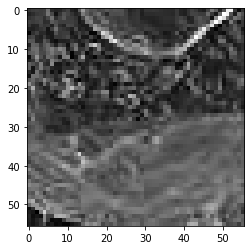

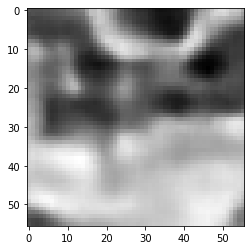

41.01286366581917

 next


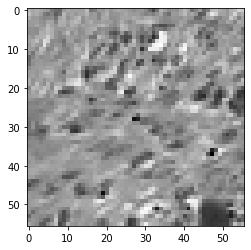

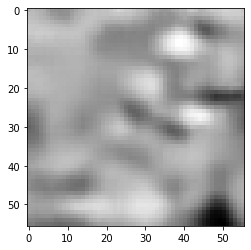

32.663457691669464

 next


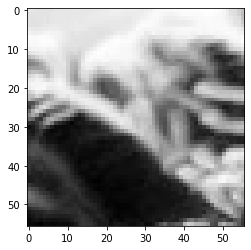

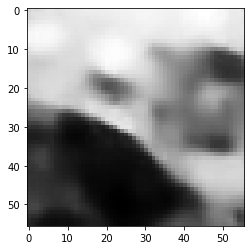

113.6329784989357

 next


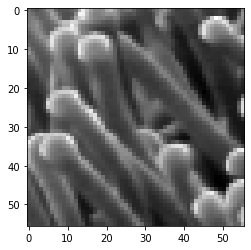

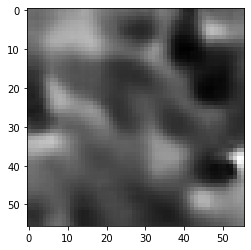

32.63888821005821

 next


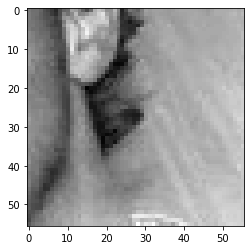

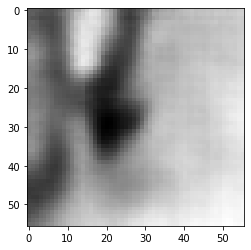

17.965285889804363

 next


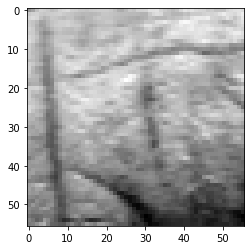

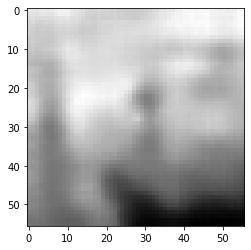

28.67966216057539

 next


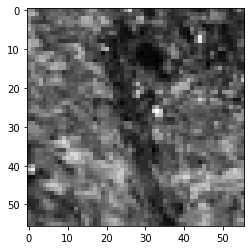

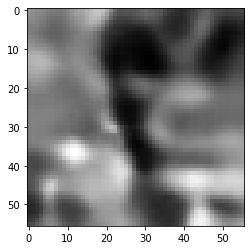

47.86739565432072

 next


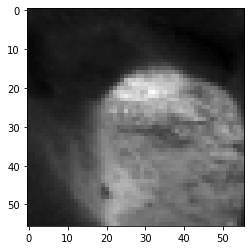

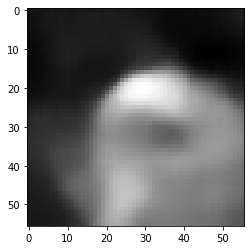

50.384323596954346

 next


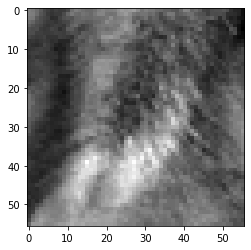

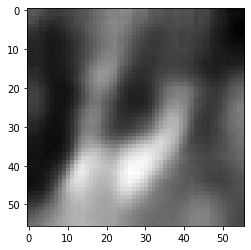

21.933051981031895

 next


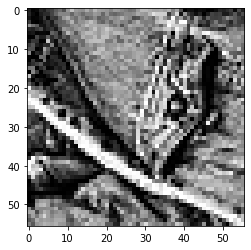

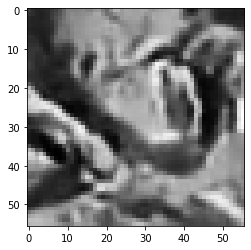

89.85871821641922

 next


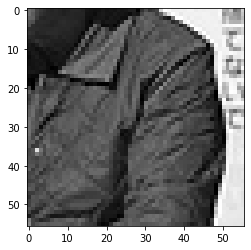

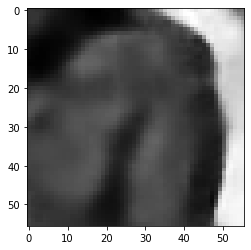

82.34753206372261

 next


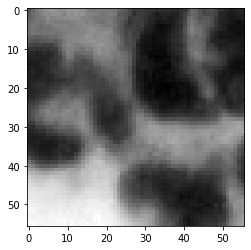

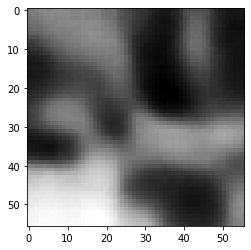

37.60963328182697

 next


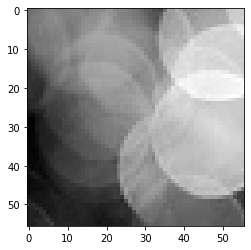

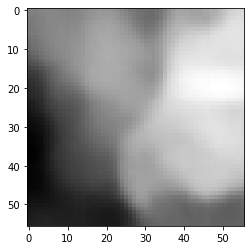

75.86387157440186

 next


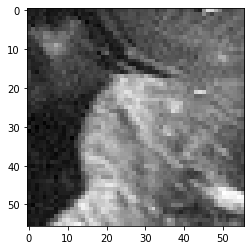

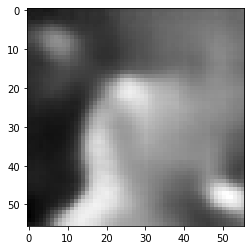

29.44044403731823

 next


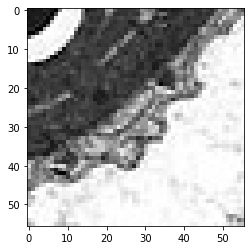

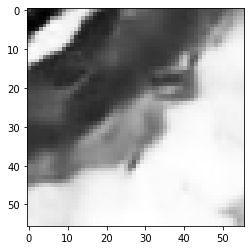

99.83999222517014

 next


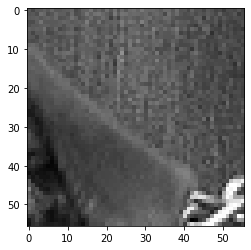

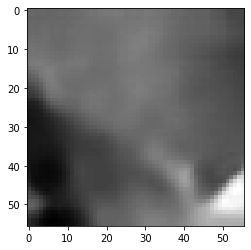

36.18902251124382

 next


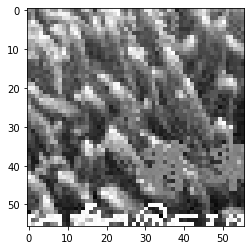

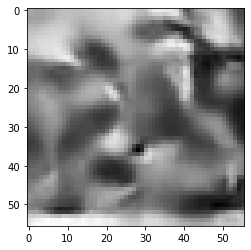

58.122159987688065

 next


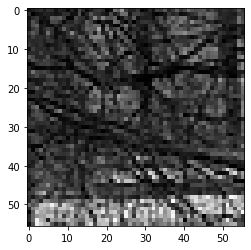

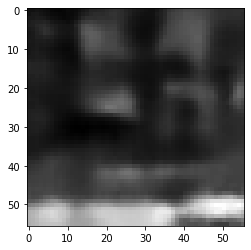

54.202708303928375

 next


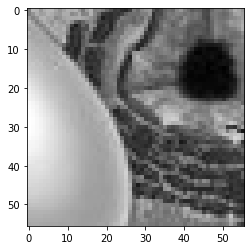

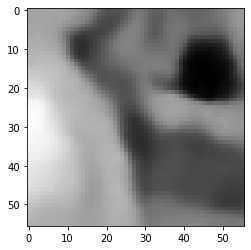

71.79349958896637

 next


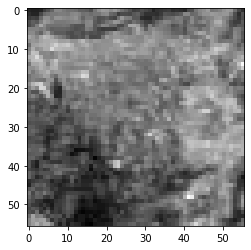

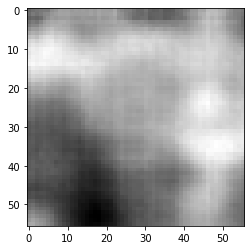

13.604960963129997

 next


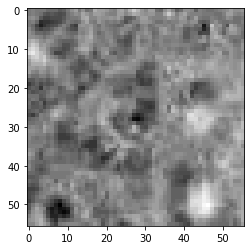

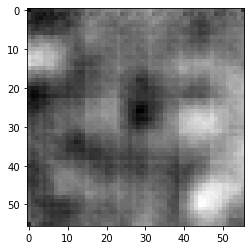

4.8424772545695305

 next


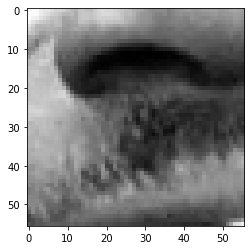

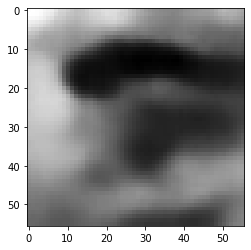

50.36154381930828

 next


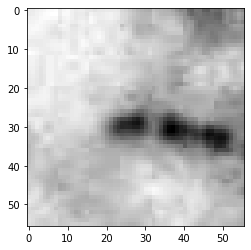

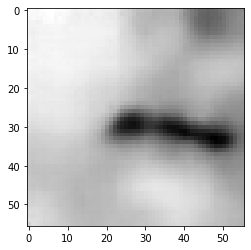

26.198262311518192

 next


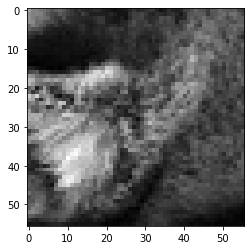

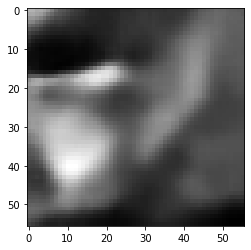

41.751433834433556

 next


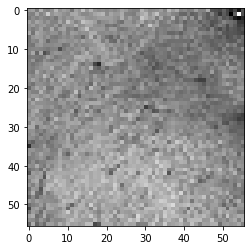

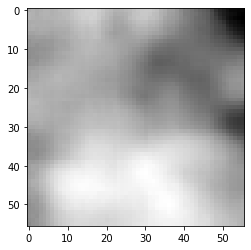

30.481407679617405

 next


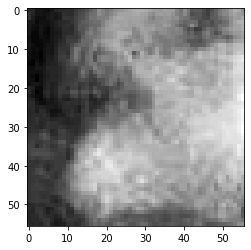

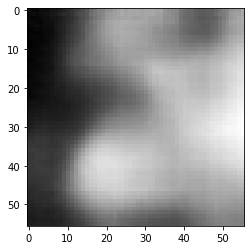

22.130141705274582

 next


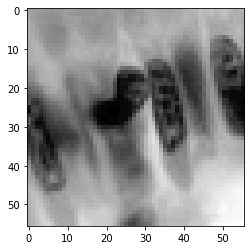

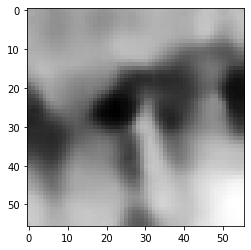

59.44138839840889

 next


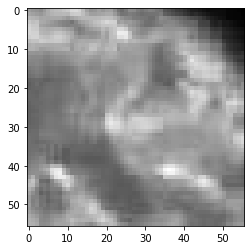

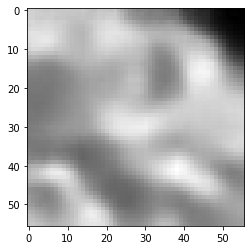

29.759991690516472

 next


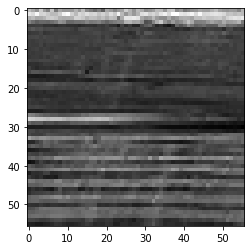

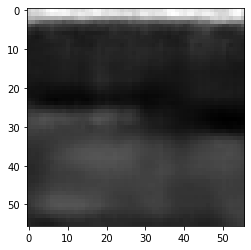

40.75490690767765

 next


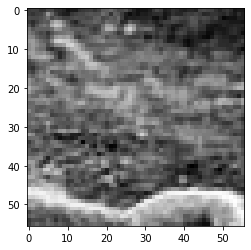

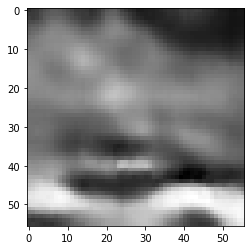

39.46505092084408

 next


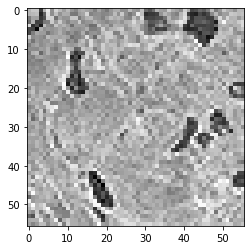

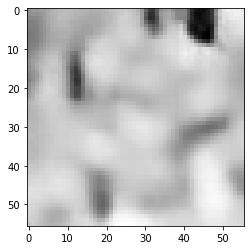

42.60747849941254

 next


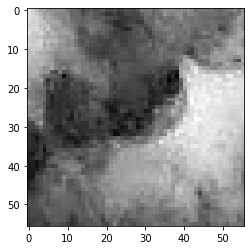

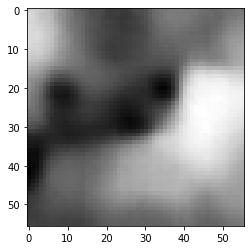

29.715712666511536

 next


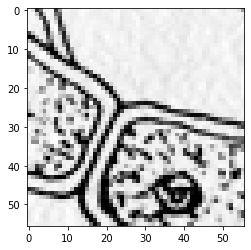

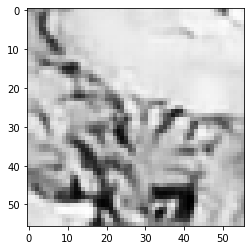

94.81246680021286

 next


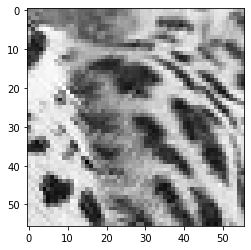

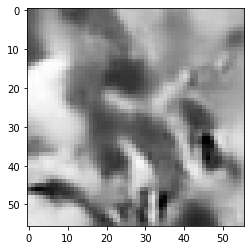

68.36830258369446

 next


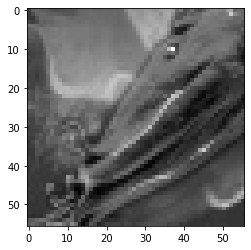

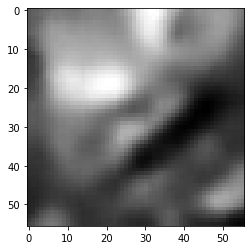

34.540910348296165

 next


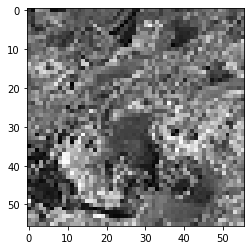

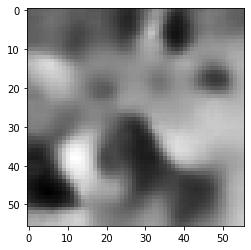

55.14932110905647

 next


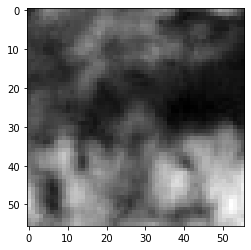

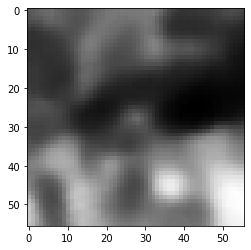

47.76266947388649

 next


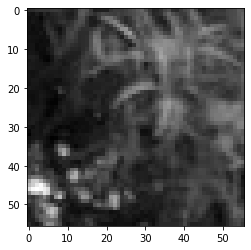

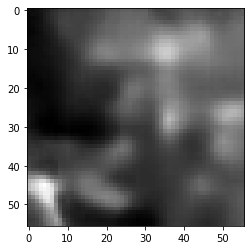

28.943670094013214

 next


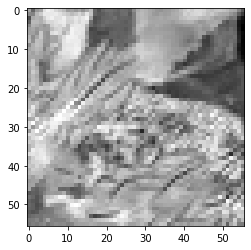

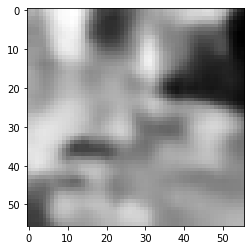

52.03547179698944

 next


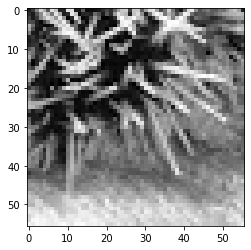

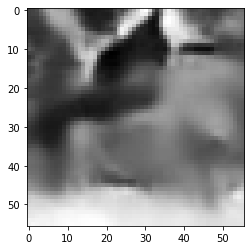

77.11978778243065

 next


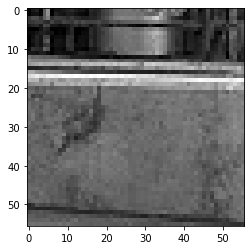

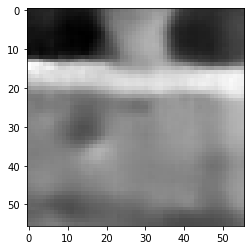

44.54666264355183

 next


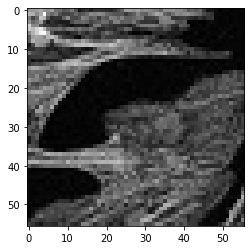

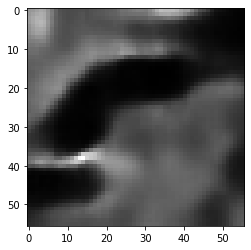

32.295952811837196

 next


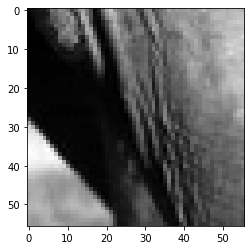

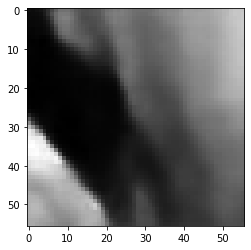

59.15495216846466

 next


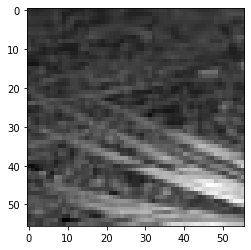

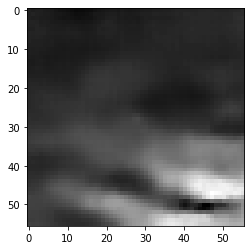

33.10183256864548

 next


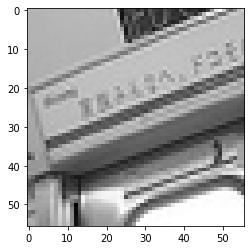

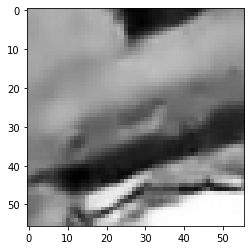

71.03544026613235

 next


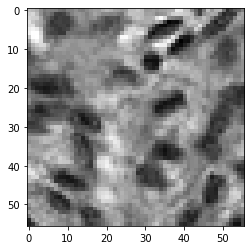

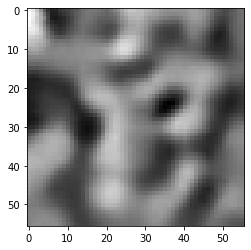

41.30877658724785

 next


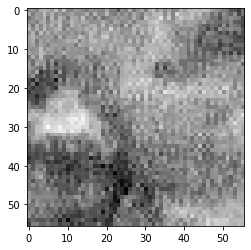

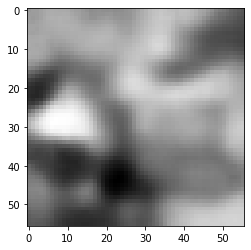

49.51586499810219

 next


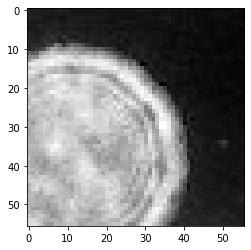

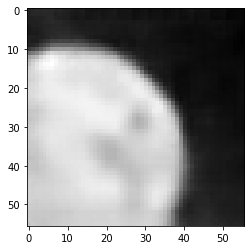

66.24086514115334

 next


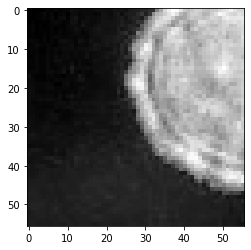

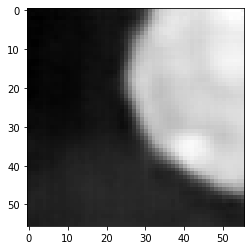

58.45346421003342

 next


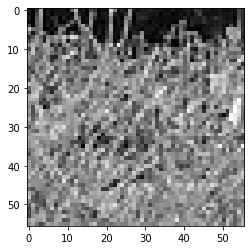

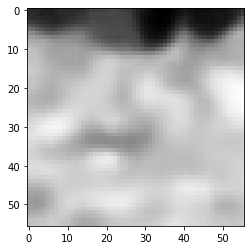

60.44367581605911

 next


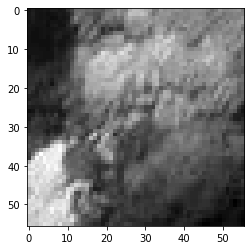

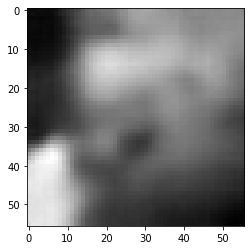

28.145811706781387

 next


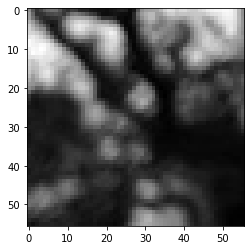

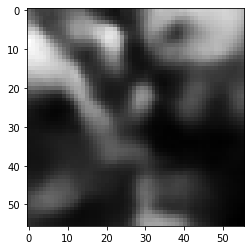

59.732855558395386

 next


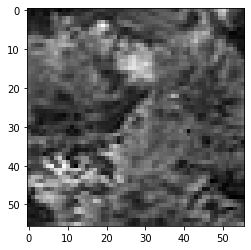

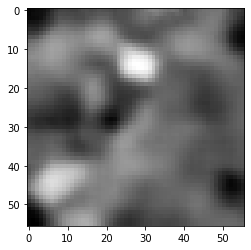

30.81346996128559

 next


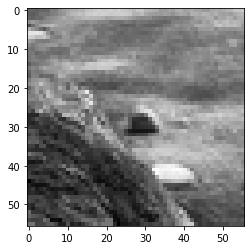

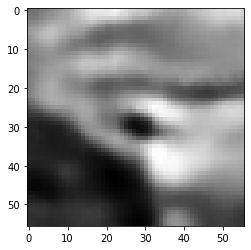

54.496812522411346

 next


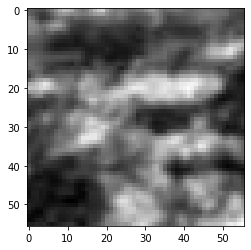

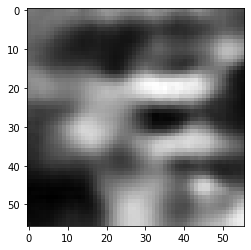

31.251048780977726

 next


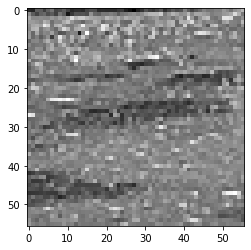

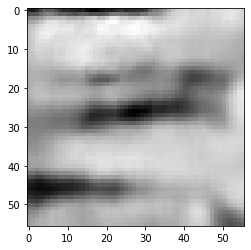

33.6490336060524

 next


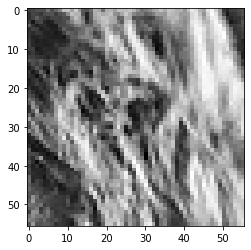

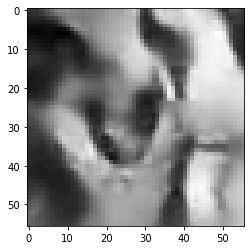

74.39940735697746

 next


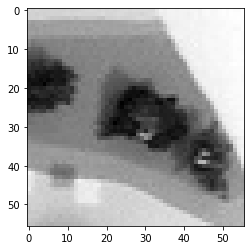

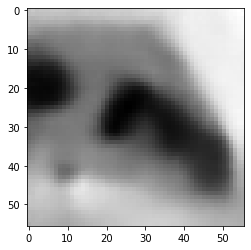

59.5499561727047

 next


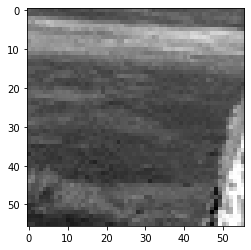

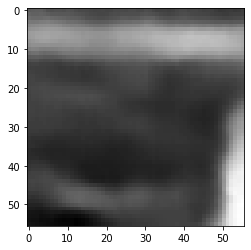

50.78939326107502

 next


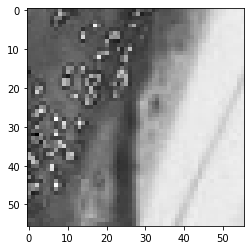

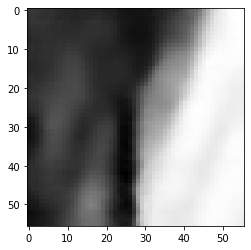

76.09468638896942

 next


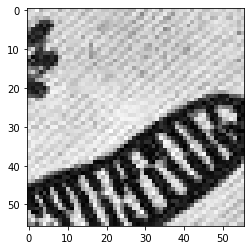

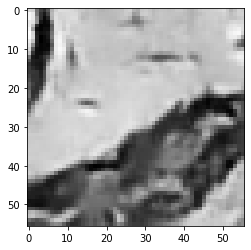

92.28703871369362

 next


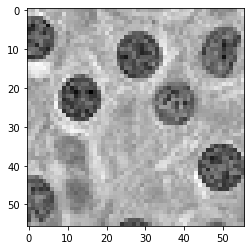

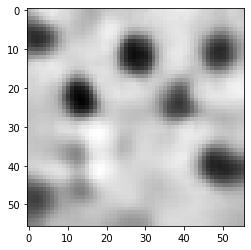

50.271405056118965

 next


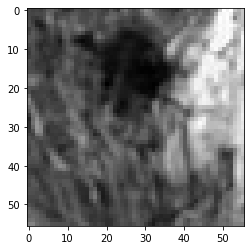

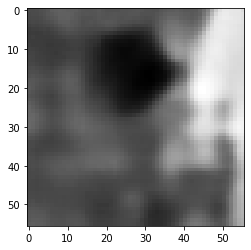

68.34802687168121

 next


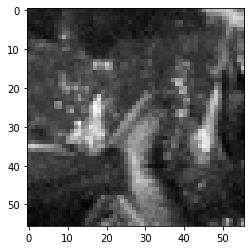

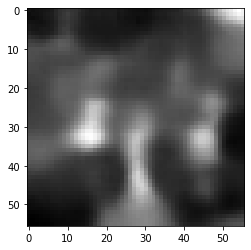

34.04802739620209

 next


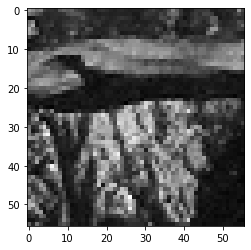

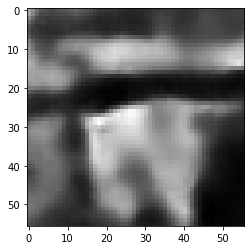

60.01686751842499

 next


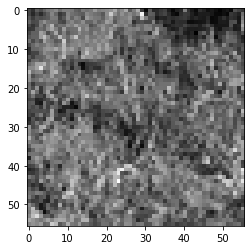

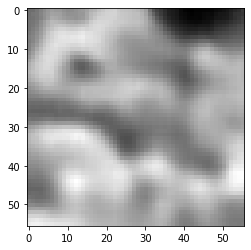

32.27236747741699

 next


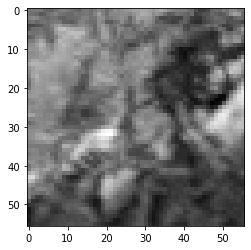

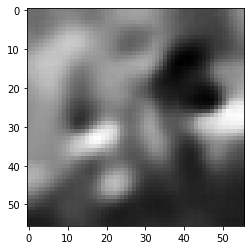

40.413369834423065

 next


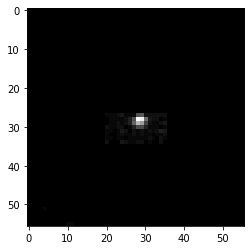

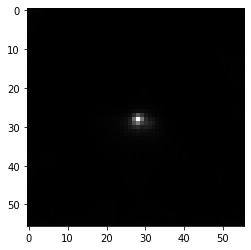

1.2971984990872443

 next


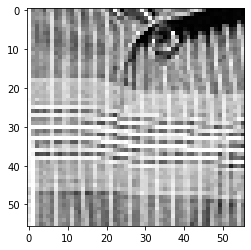

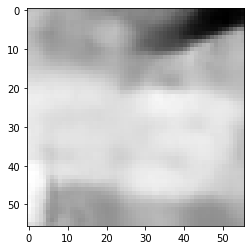

71.50911524891853

 next


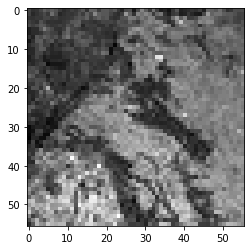

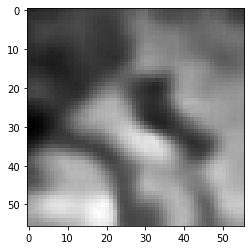

30.689564310014248

 next


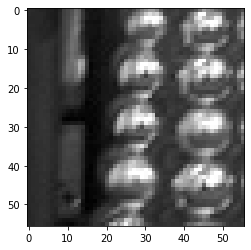

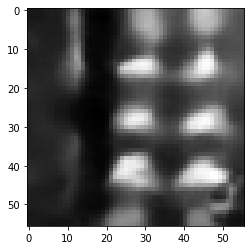

74.20252472162247

 next


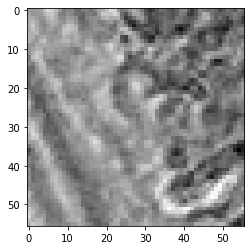

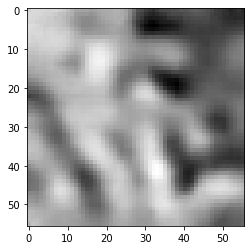

30.716314874589443

 next


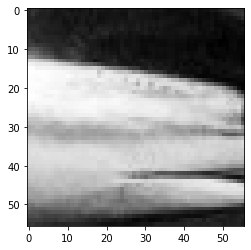

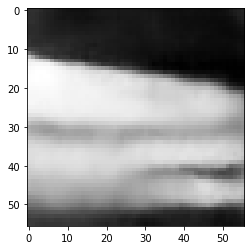

100.05551666021347

 next


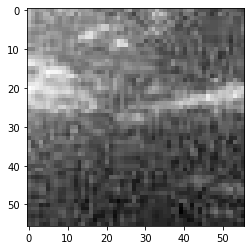

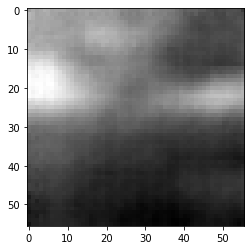

10.884946268051863

 next


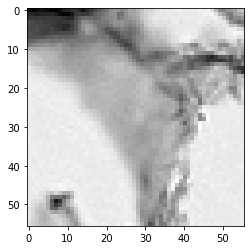

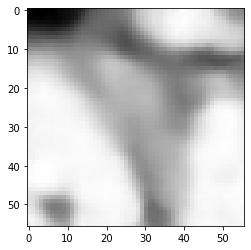

60.396197363734245

 next


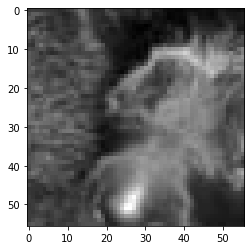

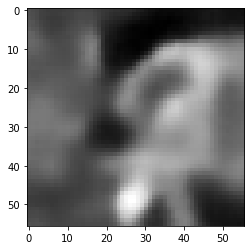

45.960597172379494

 next


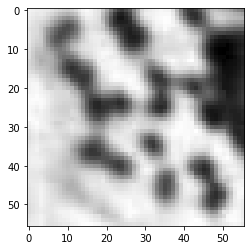

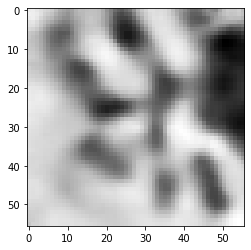

49.6970696747303

 next


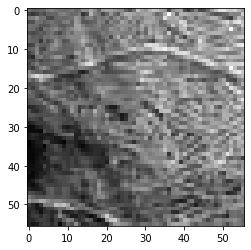

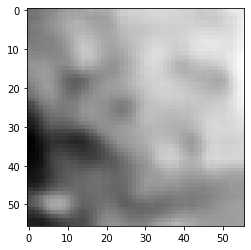

37.75884747505188

 next


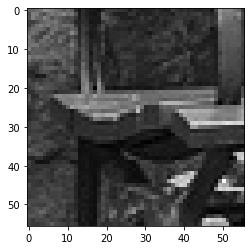

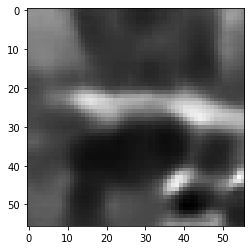

36.07461825013161

 next


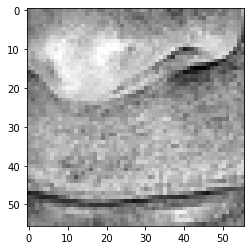

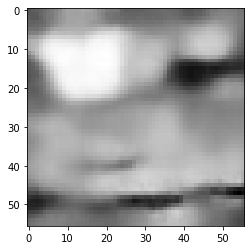

47.80265852808952

 next


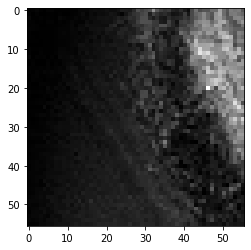

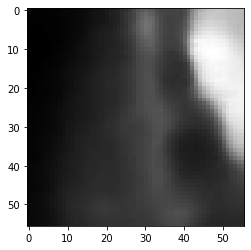

49.11868371069431

 next


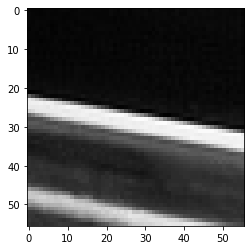

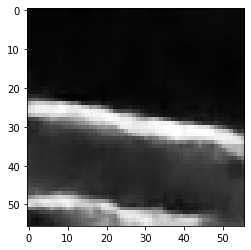

92.21025243401527

 next


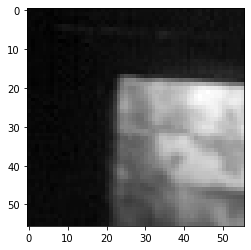

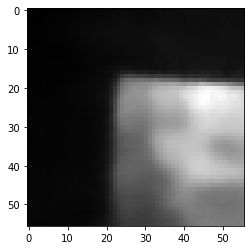

67.96326711773872

 next


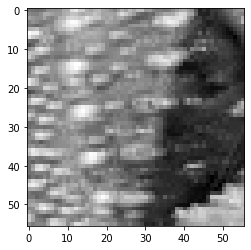

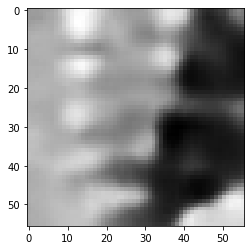

56.34477876126766

 next


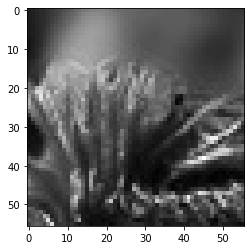

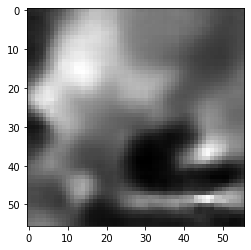

34.80104438960552

 next


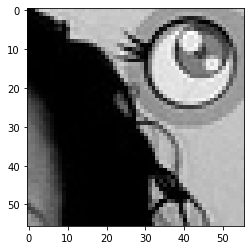

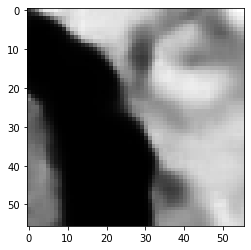

89.55021277070045

 next


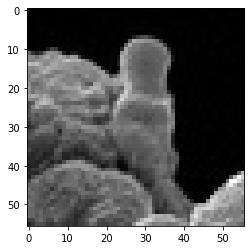

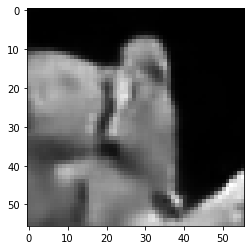

84.66563567519188

 next


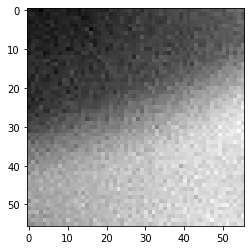

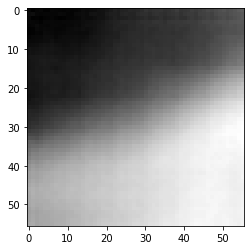

22.361393496394157

 next


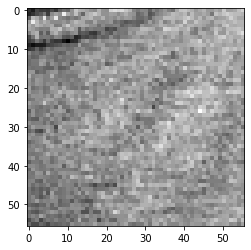

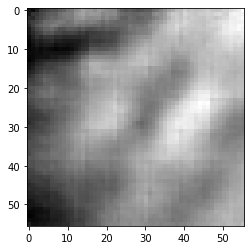

9.812508914619684

 next


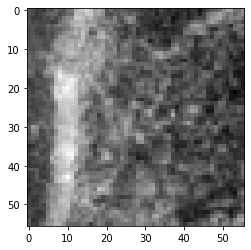

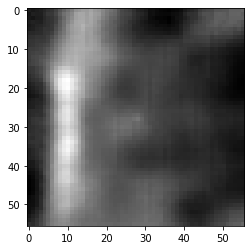

13.815691955387592

 next


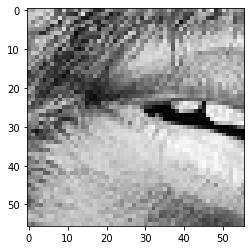

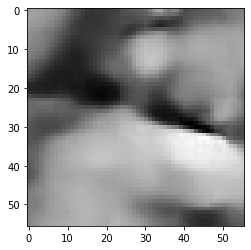

67.12058633565903

 next


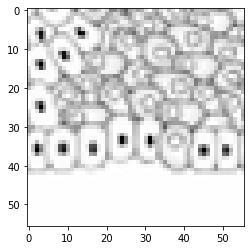

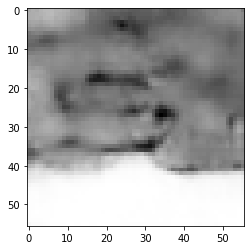

47.19011999666691

 next


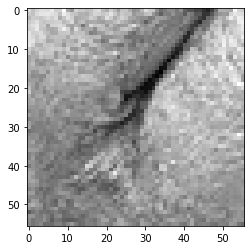

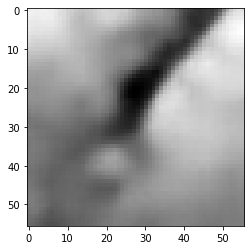

41.68596714735031

 next


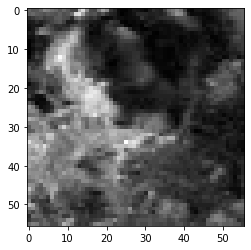

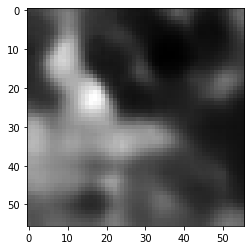

39.645951613783836

 next


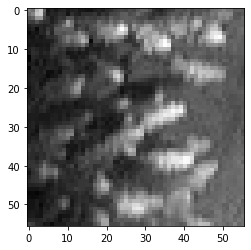

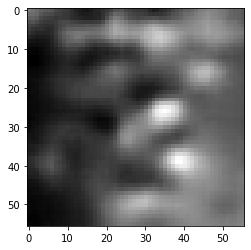

21.67903371155262

 next


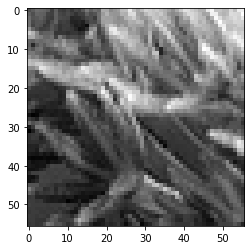

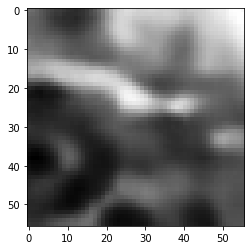

65.41604340076447

 next


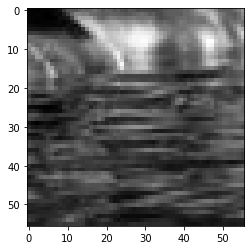

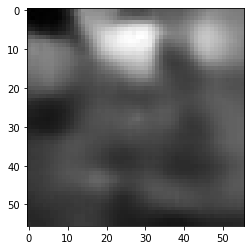

41.67240187525749

 next


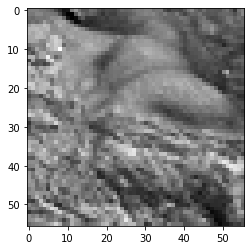

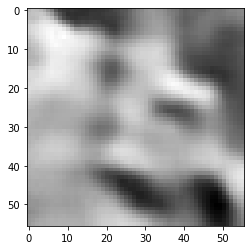

32.565487548708916

 next


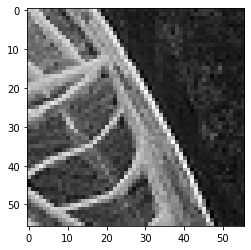

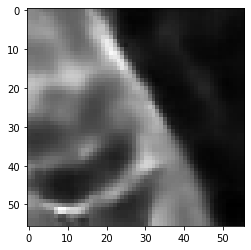

66.02319002151489

 next


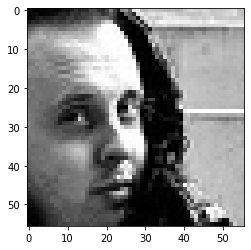

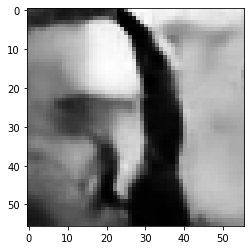

111.2516462802887

 next
0.19437290107365698


In [38]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [16]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())

# history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

# model_version = "0.0.0.5"
# vae.save_weights(base_dir + '/vae_' + model_version + '.h5')
